# Dota 2 Matchmaking: Data Cleaning & Exploration

---

## Dataset Collection & Overview

This dataset was collected by [**Devin Anzelmo**](https://www.kaggle.com/datasets/devinanzelmo/dota-2-matches/data) and contains 50,000 ranked ladder matches from the Dota 2 data dump created by [Opendota](https://www.opendota.com/). It was inspired by the [Dota 2 Matches](https://www.kaggle.com/jraramirez/dota-2-matches-dataset) data published by **Joe Ramir**. This is an updated and improved version of that dataset. The number of games in this dataset are played about every hour. 

> [**Quick look at how the dataset is structured**](https://www.kaggle.com/code/devinanzelmo/a-quick-look-at-dota-2-dataset)

|   CSV File             |  Description  | Notes |
|:-----------------------|:--------------|:------|
|  **Match Info**        |  |  |
| [match](#Matches)                  | Top-level information about each match | `tower_status` and `barracks_status` are binary masks indicating whether various structures have been destroyed |
| [players](#Players)                | Statistics about player's individual performance in each match | Some players chose to hide their account_id and are marked as `0`. Player positions are enumerated from 0 to 4 for Radiant teams, while Dire teams go from 128 to 132 |
| [player_time](#Player-Time)            | Contains XP, gold, and last-hit totals for each player at one-minute intervals | The suffix for each variable indicates the value of the `player_slot` variable |
| [teamfights](#Teamfights)             | Basic information about each team fight | `start`, `end`, and `last_death` contain the time for those events in seconds |
| [teamfights_players](#Teamfight-Players)     | Detailed info about each team fight | Each row in `teamfights.csv` corresponds to ten rows in this file |
| [chat](#Chat)                   | Chat log for all matches | These include the player's name in game |
| [objectives](#Objectives)             | Gives information on all the objectives completed, by which player and at what time |  |
| [ability_upgrades](#Ability-Upgrades)       | Contains the upgrade performed at each level for each player |  |
| [purchase_log](#Purchase-Log)           | Contains the time in seconds for each purchase made by every player in every match |  |
| **Game Info**          |  |  |
| [ability_ids](#Abilities)            | Ability names and ids | Use with `ability_upgrades.csv` to get the names of upgraded abilities |
| [item_ids](#Items)               | Contains `item_id` and item name | Use with `purchase_log.csv` to get the names of purchased items |
| [hero_ids](#Heroes)               | Contains the `name`, `hero_id`, and `localized_name` for each hero a player can pick | Concatenated this file with the one found [here](https://www.kaggle.com/datasets/nihalbarua/dota2-hero-preference-by-mmr) to obtain the `Primary Attribute` and possible Roles |
| [cluster_region](#Regions)         | Contains the cluster number and geographic region | Allows to filter matches by region |
| [patch_dates](#Patches)            | Release dates for various patches | Use `start_time` from `match.csv` to determine which patch was used to play in |
| **Historical Info**    |  |  |
| [MMR](#MMR)                    | Contains `account_id` and players' **Matchmaking Rating** *(**MMR** for short)* | File extracted from the [**OpenDota Core Wiki**](https://github.com/odota/core/wiki/MMR-Data) where the original dataset is based from |
| [player_ratings](#Player-Ratings)         | Skill data computed on **900k** previous matches and a possible way to measure skill rating when **MMR** is not available | `trueskill` ratings have two components, `mu`, which can be interpreted as the skill, with the higher value being better, and `sigma` which is the uncertainty of the rating. Negative `account_id` are players not appearing in other data available in this dataset |
| [match_outcomes](#Previous-Outcomes)         | Results with `account_id` for **900k** matches occurring prior the rest of the dataset | Each match has data on two rows. the `rad` feature indicates whether the team is Radiant or Dire. *Useful for creating custom skill calculations* |
| **Tests**              |  |  |
| [test_labels](#Test-Labels)            | `match_id` and `radiant_win` as integer 1 or 0 |  |
| [test_player](#Test-Players)            | Full player and match table with `hero_id`, `player_slot`, `match_id`, and `account_id`|  |

Despite going through the [**quick look into the dataset structure**](https://www.kaggle.com/code/devinanzelmo/a-quick-look-at-dota-2-dataset) posted above, we still need to make sure that the data is clean for EDA and modelling.

### Initial Setup

In [1]:
# Basic Data Science Libraries
import numpy as np # Linear algebra
import pandas as pd # Data processing

# System Libraries
import os # Miscellaneous operating system interfaces
import gc # Garbage collector interface
from subprocess import check_output # Saves results written to the current directory as output

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Removing the max columns limiter
pd.set_option('display.max_columns', None)

# Defining my clean and raw directory paths
clean_folder = '../Data/Clean'
raw_folder = '../Data/Raw'

# Printing files in my Raw Dataset
print(check_output(['ls', raw_folder]).decode('utf8'))

# Defining a function to read each file and learn its shape
df = {}
def read_file(file, **kwargs):
    '''
    Reads a CSV file name as a string, assigns it to a DataFrame and prints its shape

    Parameters
    ----------
    file: A string input
        string containing the name of the file to be read
        
    *index: An integer input
        Numerical value that passes along the column number of the index
    
    Returns
    -------
    df[key]: A DataFrame within the df dictionary
    '''
    index = kwargs.get('index', None)
    
    assert isinstance(file, str), 'File name must be a string'
        
    # Include CSV files exclusively
    if file.endswith('.csv'):
            
        # Construct full file path
        file_path = os.path.join(raw_folder, file)
    
        # Assign to DataFrame
        key = file.split('.csv')[0] 
        df[key] = pd.read_csv(file_path, index_col=index)
        
        # Print the shape of the file
        return print(f'{file_path}:', '{:,} observations, {:,} features'.format(df[key].shape[0], df[key].shape[1]))

MMR.csv
ability_ids.csv
ability_upgrades.csv
chat.csv
cluster_regions.csv
hero_ids.csv
item_ids.csv
match.csv
match_outcomes.csv
objectives.csv
patch_dates.csv
player_ratings.csv
player_time.csv
players.csv
purchase_log.csv
teamfights.csv
teamfights_players.csv
test_labels.csv
test_player.csv
yasp_sample.json



---

## Game Metadata

In this section, we'll review and clean all the information and metadata about the game.

### Abilities

In [2]:
# Loading up the ability_ids.csv file
read_file('ability_ids.csv', index=0)

../Data/Raw/ability_ids.csv: 688 observations, 1 features


In [3]:
# Overview of the DataFrame
df['ability_ids'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 688 entries, 0 to 10002
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ability_name  688 non-null    object
dtypes: object(1)
memory usage: 10.8+ KB


































































































































































































We can see that there are no missing values in this DataFrame. Let's look into the data itself.

In [4]:
# Looking at the first rows
df['ability_ids'].head()

,ability_name
ability_id,
0,ability_base
5001,default_attack
5002,attribute_bonus
5003,antimage_mana_break
5004,antimage_blink


Noticing that this file contains just the ability IDs and names. I'll go ahead and move it to my cleaned data folder.

In [5]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'ability_ids.csv')
df['ability_ids'].to_csv(file_path)

# Removing the file from memory
del df['ability_ids']
gc.collect()

0

### Items

In [6]:
# Loading up the item_ids.csv file
read_file('item_ids.csv', index=0)

../Data/Raw/item_ids.csv: 189 observations, 1 features


In [7]:
# Overview of the DataFrame
df['item_ids'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 1 to 1027
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_name  189 non-null    object
dtypes: object(1)
memory usage: 3.0+ KB


In [8]:
# Looking at the first rows
df['item_ids'].head()

,item_name
item_id,
1,blink
2,blades_of_attack
3,broadsword
4,chainmail
5,claymore


Same as the abilities, this file contains only the item names and IDs. I'll save it to the clean folder.

In [9]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'item_ids.csv')
df['item_ids'].to_csv(file_path)

# Removing the file from memory
del df['item_ids']
gc.collect()

0

### Heroes

In [10]:
# Loading up the hero_ids.csv file
read_file('hero_ids.csv')

../Data/Raw/hero_ids.csv: 112 observations, 5 features


In [11]:
# Overview of the DataFrame
df['hero_ids'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               112 non-null    object
 1   hero_id            112 non-null    int64 
 2   localized_name     112 non-null    object
 3   Primary Attribute  112 non-null    object
 4   Roles              112 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.5+ KB


In [12]:
# Looking at a sample of the DataFrame
df['hero_ids'].sample(10)

,name,hero_id,localized_name,Primary Attribute,Roles
12,npc_dota_hero_puck,13,Puck,int,"Initiator, Disabler, Escape, Nuker"
28,npc_dota_hero_witch_doctor,30,Witch Doctor,int,"Support, Nuker, Disabler"
18,npc_dota_hero_tiny,19,Tiny,str,"Carry, Nuker, Pusher, Initiator, Durable, Disa..."
41,npc_dota_hero_death_prophet,43,Death Prophet,int,"Carry, Pusher, Nuker, Disabler"
16,npc_dota_hero_storm_spirit,17,Storm Spirit,int,"Carry, Escape, Nuker, Initiator, Disabler"
49,npc_dota_hero_rattletrap,51,Clockwerk,all,"Initiator, Disabler, Durable, Nuker"
37,npc_dota_hero_queenofpain,39,Queen of Pain,int,"Carry, Nuker, Escape"
71,npc_dota_hero_alchemist,73,Alchemist,str,"Carry, Support, Durable, Disabler, Initiator, ..."
102,npc_dota_hero_legion_commander,104,Legion Commander,str,"Carry, Disabler, Initiator, Durable, Nuker"
54,npc_dota_hero_clinkz,56,Clinkz,agi,"Carry, Escape, Pusher"


The roles appear to contain multiple traits that would make more sense if they were inside a set *(since I'm not interested in them having a particular order but don't want any duplicates)*. I have also observed that the `name` and `localized_name` fields contain similar values, so I will remove the `name` column and set the `hero_id` as its index.

In [13]:
# Setting the hero_id as the index
df['hero_ids'].set_index('hero_id', inplace=True)

# Dropping the name feature since it is redundant
df['hero_ids'].drop(columns='name', inplace=True)

# Renaming the localized_name to name and formatting Primary Attribute and Roles to follow the same as the rest
df['hero_ids'].rename(columns={'localized_name': 'name', 'Primary Attribute': 'primary_attribute', 'Roles': 'roles'},
                      inplace=True)

# Changing the Role values to list type
df['hero_ids']['roles'] = df['hero_ids']['roles'].apply(lambda x: set(x.split(', ')) if isinstance(x, str) else [])

# Looking at the first rows
df['hero_ids'].head()

,name,primary_attribute,roles
hero_id,,,
1,Anti-Mage,agi,"{Nuker, Escape, Carry}"
2,Axe,str,"{Disabler, Durable, Carry, Initiator}"
3,Bane,all,"{Disabler, Nuker, Durable, Support}"
4,Bloodseeker,agi,"{Disabler, Nuker, Carry, Initiator}"
5,Crystal Maiden,int,"{Disabler, Nuker, Support}"


In [14]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'hero_ids.csv')
df['hero_ids'].to_csv(file_path)

# Removing the file from memory
del df['hero_ids']
gc.collect()

0

### Regions

In [15]:
# Loading up the cluster_regions.csv file
read_file('cluster_regions.csv')

../Data/Raw/cluster_regions.csv: 53 observations, 2 features


In [16]:
# Overview of the DataFrame
df['cluster_regions'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cluster  53 non-null     int64 
 1   region   53 non-null     object
dtypes: int64(1), object(1)
memory usage: 976.0+ bytes


In [17]:
# Looking at the DataFrame
df['cluster_regions']

,cluster,region
0,111,US WEST
1,112,US WEST
2,113,US WEST
3,121,US EAST
4,122,US EAST
5,123,US EAST
6,124,US EAST
7,131,EUROPE
8,132,EUROPE
9,133,EUROPE


This file only showcases the clusters *(which we can assume are game servers)* and their region. However, it might be more accessible if we grouped the clusters by region.

In [18]:
# Converting the DataFrame into a dictionary with clusters as sets
df['cluster_regions'] = pd.DataFrame(df['cluster_regions'].groupby('region')['cluster'].apply(set))
df['cluster_regions']

,cluster
region,
AUSTRALIA,"{171, 172}"
AUSTRIA,"{192, 193, 191}"
BRAZIL,"{201, 202, 204}"
CHILE,"{241, 242}"
DUBAI,{161}
EUROPE,"{131, 132, 133, 134, 135, 136, 137, 138}"
INDIA,{261}
JAPAN,"{144, 145}"
PERU,{251}


In [19]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'regions.csv')
df['cluster_regions'].to_csv(file_path)

# Removing the file from memory
del df['cluster_regions']
gc.collect()

0

### Patches

In [20]:
# Loading up the patch_dates.csv file
read_file('patch_dates.csv')

../Data/Raw/patch_dates.csv: 19 observations, 2 features


In [21]:
# Overview of the DataFrame
df['patch_dates'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patch_date  19 non-null     object 
 1   name        19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


In [22]:
# Looking at the DataFrame
df['patch_dates']

,patch_date,name
0,2010-12-24T00:00:00Z,6.70
1,2011-01-21T00:00:00Z,6.71
2,2011-04-27T00:00:00Z,6.72
3,2011-12-24T00:00:00Z,6.73
4,2012-03-10T00:00:00Z,6.74
5,2012-09-30T00:00:00Z,6.75
6,2012-10-21T00:00:00Z,6.76
7,2012-12-15T00:00:00Z,6.77
8,2013-05-30T00:00:00Z,6.78
9,2013-11-24T00:00:00Z,6.79


Apart from changing the `patch_date` type, I'll change the index to the patch name and save it.

In [23]:
# Obtaining the original datatype
print('Orignial Data type:\n', df['patch_dates'].dtypes['patch_date'])

# Updating to DateTime type
df['patch_dates']['patch_date'] = pd.to_datetime(df['patch_dates']['patch_date'], yearfirst=True)
print('\nUpdated Data type:\n', df['patch_dates'].dtypes['patch_date'])

Orignial Data type:
 object

Updated Data type:
 datetime64[ns, UTC]


In [24]:
# Setting up the name as index
df['patch_dates'].set_index('name', inplace=True)
df['patch_dates']

,patch_date
name,
6.70,2010-12-24 00:00:00+00:00
6.71,2011-01-21 00:00:00+00:00
6.72,2011-04-27 00:00:00+00:00
6.73,2011-12-24 00:00:00+00:00
6.74,2012-03-10 00:00:00+00:00
6.75,2012-09-30 00:00:00+00:00
6.76,2012-10-21 00:00:00+00:00
6.77,2012-12-15 00:00:00+00:00
6.78,2013-05-30 00:00:00+00:00


In [25]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'patch_dates.csv')
df['patch_dates'].to_csv(file_path)

# Removing the file from memory
del df['patch_dates']
gc.collect()

0

### Positions

I've decided to create a new file to include the relationship between each player' position within the game and other relevant in-game data

In [26]:
positions = pd.DataFrame({
    'player_slot': [0,1,2,3,4, # Player positions for Radiant team
                    128,129,130,131,132], # Player positions for Dire team
    'side': ['Radiant','Radiant','Radiant','Radiant','Radiant', # Radiant team indicator
             'Dire','Dire','Dire','Dire','Dire'], # Dire team indicator
    'position': ['Carry', 'Midlaner', 'Offlaner', 'Roamer', 'Hard Support', # Position names for Radiant team
                 'Carry', 'Midlaner', 'Offlaner', 'Roamer', 'Hard Support'], # Position names for Dire team
    'roles': [{'Carry','Escape','Pushers'}, # Slot 0 roles
              {'Carry','Durable','Pushers','Disabler','Nuker'}, # Slot 1 roles
              {'Carry','Durable','Initiator','Pushers','Disabler'}, # Slot 2 roles
              {'Support','Escape','Initiator','Disabler'}, # Slot 3 roles
              {'Support','Escape','Initiator','Disabler'}, # Slot 4 roles
              {'Carry','Escape','Pushers'}, # Slot 128 roles
              {'Carry','Durable','Pushers','Disabler','Nuker'}, # Slot 129 roles
              {'Carry','Durable','Initiator','Pushers','Disabler'}, # Slot 130 roles
              {'Support','Escape','Initiator','Disabler'}, # Slot 131 roles
              {'Support','Escape','Initiator','Disabler'}], # Slot 132 roles
}).set_index('player_slot')

# Taking a look into the created DataFrame
positions

,side,position,roles
player_slot,,,
0,Radiant,Carry,"{Pushers, Escape, Carry}"
1,Radiant,Midlaner,"{Pushers, Nuker, Carry, Disabler, Durable}"
2,Radiant,Offlaner,"{Pushers, Carry, Initiator, Disabler, Durable}"
3,Radiant,Roamer,"{Disabler, Escape, Support, Initiator}"
4,Radiant,Hard Support,"{Disabler, Escape, Support, Initiator}"
128,Dire,Carry,"{Pushers, Escape, Carry}"
129,Dire,Midlaner,"{Pushers, Nuker, Carry, Disabler, Durable}"
130,Dire,Offlaner,"{Pushers, Carry, Initiator, Disabler, Durable}"
131,Dire,Roamer,"{Disabler, Escape, Support, Initiator}"


In [27]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'positions.csv')
positions.to_csv(file_path)

# Removing the file from memory
del positions
gc.collect()

0

---
## Match Data

This section will review and clean all the data containing the 50,000 matches. Since most of these files might interconnect with each other, its best if we load them all up at once.

### Matches

In [28]:
# Loading up the match.csv file
read_file('match.csv')

../Data/Raw/match.csv: 50,000 observations, 13 features


In [29]:
# Overview of the DataFrame
df['match'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   match_id                 50000 non-null  int64
 1   start_time               50000 non-null  int64
 2   duration                 50000 non-null  int64
 3   tower_status_radiant     50000 non-null  int64
 4   tower_status_dire        50000 non-null  int64
 5   barracks_status_dire     50000 non-null  int64
 6   barracks_status_radiant  50000 non-null  int64
 7   first_blood_time         50000 non-null  int64
 8   game_mode                50000 non-null  int64
 9   radiant_win              50000 non-null  bool 
 10  negative_votes           50000 non-null  int64
 11  positive_votes           50000 non-null  int64
 12  cluster                  50000 non-null  int64
dtypes: bool(1), int64(12)
memory usage: 4.6 MB


In [30]:
# Looking at the DataFrame
df['match'].sample(20)

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
34365,34365,1447654945,1608,2046,4,3,63,199,22,True,0,0,112
22234,22234,1447548795,1648,1855,0,0,63,110,22,True,0,0,156
15930,15930,1447492175,1858,1983,0,0,63,138,22,True,0,0,153
10062,10062,1447433909,2235,7,2036,63,3,45,22,False,0,0,182
39100,39100,1447713350,2389,0,1974,63,0,44,22,False,0,0,123
11661,11661,1447449205,2118,2047,6,3,63,33,2,True,0,0,133
16896,16896,1447506276,2962,1972,0,0,63,313,22,True,0,0,133
27617,27617,1447600585,2275,1975,0,0,63,0,22,True,0,0,182
15967,15967,1447492616,3130,1846,0,0,63,79,22,True,0,0,171
27206,27206,1447597678,2955,0,1828,63,0,48,2,False,0,0,138


#### Understanding the values

At a first glance the data seems clean enough, however, to understand the values of each feature better, I found out in [**Devin's quick look**](https://www.kaggle.com/code/devinanzelmo/a-quick-look-at-dota-2-dataset/notebook) that the [**Player Slots**](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Player_Slot), [**Tower Status**](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status), and [**Barracks Status**](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Barracks_Status) are binary masks indicating whether some conditions have been met.

##### Player Slot

A player's slot is returned via an 8-bit unsigned integer. The first bit represent the player's team, false if Radiant and true if dire. The final three bits represent the player's position in that team, from 0-4.
```
   ┌─────────────── Team (false if Radiant, true if Dire).
   │ ┌─┬─┬─┬─────── Not used.
   │ │ │ │ │ ┌─┬─┬─ The position of a player within their team (0-4).
   │ │ │ │ │ │ │ │
   0 0 0 0 0 0 0 0
```

##### Tower Status

A particular teams tower status is given as a 16-bit unsigned integer. The rightmost 11 bits represent individual towers belonging to that team; see below for a visual representation.
```
   ┌─┬─┬─┬─┬─────────────────────── Not used.
   │ │ │ │ │ ┌───────────────────── Ancient Bottom
   │ │ │ │ │ │ ┌─────────────────── Ancient Top
   │ │ │ │ │ │ │ ┌───────────────── Bottom Tier 3
   │ │ │ │ │ │ │ │ ┌─────────────── Bottom Tier 2
   │ │ │ │ │ │ │ │ │ ┌───────────── Bottom Tier 1
   │ │ │ │ │ │ │ │ │ │ ┌─────────── Middle Tier 3
   │ │ │ │ │ │ │ │ │ │ │ ┌───────── Middle Tier 2
   │ │ │ │ │ │ │ │ │ │ │ │ ┌─────── Middle Tier 1
   │ │ │ │ │ │ │ │ │ │ │ │ │ ┌───── Top Tier 3
   │ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─── Top Tier 2
   │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─ Top Tier 1
   │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

```

##### Barracks Status

A particular teams tower status is given as an 8-bit unsigned integer. The rightmost 6 bits represent the barracks belonging to that team; see below for a visual representation.
```
   ┌─┬───────────── Not used.
   │ │ ┌─────────── Bottom Ranged
   │ │ │ ┌───────── Bottom Melee
   │ │ │ │ ┌─────── Middle Ranged
   │ │ │ │ │ ┌───── Middle Melee
   │ │ │ │ │ │ ┌─── Top Ranged
   │ │ │ │ │ │ │ ┌─ Top Melee
   │ │ │ │ │ │ │ │
   0 0 0 0 0 0 0 0
```

##### Game Mode
0. None
1. All Pick
2. Captain's Mode
3. Random Draft
4. Single Draft
5. All Random
6. Intro
7. Diretide
8. Reverse Captain's Mode
9. The Greeviling
10. Tutorial
11. Mid Only
12. Least Played
13. New Player Pool
14. Compendium Matchmaking
15. Co-op vs Bots
16. Captains Draft
18. Ability Draft
20. All Random Deathmatch
21. 1v1 Mid Only
22. Ranked Matchmaking
23. Turbo Mode

<div class="alert alert-block alert-info"> <b>Note:</b> Since all of the matches collected in this dataset were gathered from Ranked Matchmaking, it might be safe to assume that the <b>Game Mode</b> column is irrelevant to keep. </div>

##### Positive & Negative Votes

The number of thumbs-up *(Positive)* and thumbs-down *(Negative)* the game has received by users
<div class="alert alert-block alert-info"> <b>Note:</b> <i>This might be a useful feature for the profiling modelling (i.e. "entertainers")</i></div>

In [31]:
# Checking the unique values for Game Mode
df['match']['game_mode'].unique()

array([22,  2])

In [32]:
# Filtering the matches with a game mode of 2
df['match'][df['match']['game_mode'] == 2]

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
114,114,1447095154,2714,1828,0,0,63,0,2,True,0,0,132
115,115,1447096920,2702,1972,0,0,63,270,2,True,0,0,132
121,121,1447100637,2760,0,1844,63,0,268,2,False,0,0,133
149,149,1447149824,2298,1798,0,0,63,94,2,True,0,0,155
216,216,1447253856,2909,0,1924,63,0,42,2,False,0,0,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49578,49578,1447823526,1773,0,2046,63,0,89,2,False,0,0,123
49649,49649,1447824307,3137,4,1824,60,51,16,2,False,0,0,138
49708,49708,1447825225,1663,2038,0,0,63,0,2,True,0,0,122
49726,49726,1447825433,2152,1855,0,0,63,114,2,True,0,1,111


According to the [**Dota 2 Wiki**](https://dota2.fandom.com/wiki/Game_modes#Captains_Mode), the Captain's Mode is another form of ranked matchmaking were only the captain of each team picks and bans the heroes for their team. It is the standard format for tournament games.

I'll keep the feature for now to profile the players that have participated in a tournament or not.

#### Duplicated Observations

In [33]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['match'].duplicated().sum(),
                                           round((df['match'].duplicated().sum()/df['match'].shape[0])*100,2)))

Duplicated rows: 0 (0.0)%


#### Data Formatting

Although the DataFrame seems pretty clean, the `start_time` is in Unix code, and the `radiant_win` is boolean. Let's keep the Unix code in mind for any upcoming time-related features, and change the boolean values to binary.

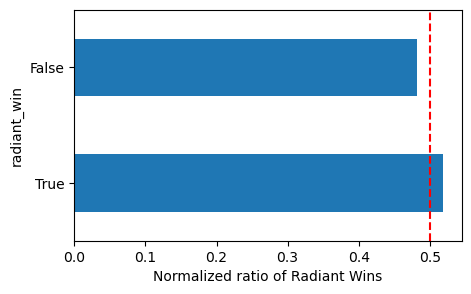

In [34]:
# Visualizing the target column radiant_win
df['match']['radiant_win'].value_counts(normalize=True).plot(kind='barh', figsize=(5,3))
plt.axvline(0.5, ls='--', c='red')
plt.xlabel('Normalized ratio of Radiant Wins')
plt.show()

We have a very balanced dataset, which means we can go ahead and convert it to a binary column.

In [35]:
# Converting 'True' and 'False' to binary values
df['match']['radiant_win'] = (df['match']['radiant_win'] == True).astype('Int64')

# Checking the updated column
df['match']['radiant_win'].value_counts(normalize=True)

radiant_win
1    0.51886
0    0.48114
Name: proportion, dtype: Float64

#### Filling Missing Values

In [36]:
# Checking for null values
df['match'].isna().sum()

match_id                   0
start_time                 0
duration                   0
tower_status_radiant       0
tower_status_dire          0
barracks_status_dire       0
barracks_status_radiant    0
first_blood_time           0
game_mode                  0
radiant_win                0
negative_votes             0
positive_votes             0
cluster                    0
dtype: int64

The DataFrame doesn't hold any null values, so we'll go ahead and export it to our cleaned directory.

#### Export & Maintenance

In [37]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'matches.csv')
df['match'].to_csv(file_path)

# Removing the file from memory
del df['match']
gc.collect()

3036

### Chat

#### DataFrame Overview

Next, we'll explore the data from our chat log. 

In [38]:
# Loading up the chat.csv file
read_file('chat.csv')

../Data/Raw/chat.csv: 1,439,488 observations, 5 features


In [39]:
# Overview of the DataFrame
df['chat'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439488 entries, 0 to 1439487
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   match_id  1439488 non-null  int64 
 1   key       1439474 non-null  object
 2   slot      1439488 non-null  int64 
 3   time      1439488 non-null  int64 
 4   unit      1439439 non-null  object
dtypes: int64(3), object(2)
memory usage: 54.9+ MB


In [40]:
# Looking at the DataFrame
df['chat'].sample(20)

,match_id,key,slot,time,unit
50363,1621,...,3,309,Unstoppable
551564,18960,gg,2,2293,kgeekay
1110084,38817,dick stuck in ceiling fan,9,2771,ILoveHorses
617326,21444,to strong for us,4,2758,Jackie Tyan
398021,13563,lol,8,2345,Nothing's Forever ..
1121266,39229,we lose to enigma without bkb but scepter ,6,2104,No Mercy BoyZ
246049,8254,nice gank,6,1054,Jed ft w33
56630,1822,who la,1,1864,HEY GUYS
615054,21377,u won this game only cause sf,0,1616,Stoly
1127130,39417,ZZ,0,58,la Flama Blanca


#### Data Formatting

I noticed that the chat DataFrame doesn't follow the conventions of the rest of the files for the Dire team positions (128 to 132) and doesn't include the account ID but instead displays the account itself. If we want to extract the account name and merge it into other DataFrames that include the match ID and player slot, creating a new auxiliary column that combines the match ID and the player slot would be best.

Additionally, the formatting of the column names doesn't match the rest of our DataFrames. Let's change the formatting in the column names and the player slot values to match the rest of the dataset.

##### Renaming the columns

In [41]:
# Renaming the columns
df['chat'].rename(columns={'key': 'chat', 'slot': 'player_slot', 'unit': 'account'}, inplace=True)

# Changing the column order
df['chat'] = df['chat'][['match_id', 'player_slot', 'account', 'chat', 'time']]
df['chat'].sample(10)

,match_id,player_slot,account,chat,time
872233,30574,2,Killua,sry m8*,2172
1099944,38442,5,So Much Hate!,ez,1588
1376295,47904,3,just a small town girl,learned alot to NOT how to play offlane,2410
1216984,42308,8,Shade,die and pasue,155
810118,28156,4,`v,yep,805
1343264,46777,3,it's funny,ахахха,2322
625294,21726,1,▓***LINUXツ***▓,y perdieron TF sin mi jaja,2367
977631,34237,8,PENIS LORD,wtf,-53
360411,12300,1,[MNI] MTB JR.,lol,884
366359,12518,9,tasoulis,oh yea,504


##### Formatting the player slots to follow convention

In [42]:
# Checking the unique values in player_slot
print('Unique values:', df['chat']['player_slot'].nunique())
np.sort(df['chat']['player_slot'].unique())

Unique values: 11


array([-9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [43]:
# Checking the rows with a player slot value = -9
df['chat'].loc[df['chat']['player_slot'] == -9, :]

,match_id,player_slot,account,chat,time
245074,8216,-9,Разрыватель пука,зарание спасибо,-343
332431,11215,-9,F@lcoN,nazi army,-522
489758,16613,-9,VaiBy <3 #Miracle Boi :D,to ez,-429
652287,22654,-9,Dana,ggwp,-450


Looks like there's only 4 observations with a `-9` player slot, and all of them have negative times indicating these messages were sent prior the start of the match. I believe that the `-9` value is for players who didn't pick a slot before the match started and were later assigned one.

In [44]:
# Checking one of those match IDs with the same account 
df['chat'].loc[(df['chat']['match_id'] == 22654) & (df['chat']['account'] == 'Dana'), :]

,match_id,player_slot,account,chat,time
652287,22654,-9,Dana,ggwp,-450
652297,22654,3,Dana,yeah !,-42
652335,22654,3,Dana,yeah,25
652336,22654,3,Dana,xD,28
652343,22654,3,Dana,what ?,171
652352,22654,3,Dana,423 nga akin x(,786
652354,22654,3,Dana,Yeah,804
652359,22654,3,Dana,xP,1482
652361,22654,3,Dana,xD,1552
652382,22654,3,Dana,ggwp,2426


Just as suspected, the player's slot value changed once they chose a slot or the match started. I'll check the other values just to be sure and proceed to change them to their right value.

In [45]:
# Replacing the value for Dana in match 22654
Dana_mask = (df['chat']['match_id'] == 22654) & \
            (df['chat']['account'] == 'Dana') & \
            (df['chat']['player_slot'] == -9)

df['chat'].loc[Dana_mask,'player_slot'] = 3
df['chat'].loc[(df['chat']['match_id'] == 22654) & (df['chat']['account'] == 'Dana'), :]

,match_id,player_slot,account,chat,time
652287,22654,3,Dana,ggwp,-450
652297,22654,3,Dana,yeah !,-42
652335,22654,3,Dana,yeah,25
652336,22654,3,Dana,xD,28
652343,22654,3,Dana,what ?,171
652352,22654,3,Dana,423 nga akin x(,786
652354,22654,3,Dana,Yeah,804
652359,22654,3,Dana,xP,1482
652361,22654,3,Dana,xD,1552
652382,22654,3,Dana,ggwp,2426


In [46]:
# Checking the player slot for VaiBy
df['chat'].loc[(df['chat']['match_id'] == 16613) & (df['chat']['account'] == 'VaiBy <3 #Miracle Boi :D'), :]

,match_id,player_slot,account,chat,time
489758,16613,-9,VaiBy <3 #Miracle Boi :D,to ez,-429
489759,16613,9,VaiBy <3 #Miracle Boi :D,_ping,355
489762,16613,9,VaiBy <3 #Miracle Boi :D,ez,889
489763,16613,9,VaiBy <3 #Miracle Boi :D,Scrubs,893
489764,16613,9,VaiBy <3 #Miracle Boi :D,.,933
489765,16613,9,VaiBy <3 #Miracle Boi :D,ill revenge,938
489770,16613,9,VaiBy <3 #Miracle Boi :D,ez mmr,2539
489776,16613,9,VaiBy <3 #Miracle Boi :D,yaya,2555


In [47]:
# Replacing the value for VaiBy in match 16613
VaiBy_mask = (df['chat']['match_id'] == 16613) & \
            (df['chat']['account'] == 'VaiBy <3 #Miracle Boi :D') & \
            (df['chat']['player_slot'] == -9)

df['chat'].loc[VaiBy_mask,'player_slot'] = 9
df['chat'].loc[(df['chat']['match_id'] == 16613) & (df['chat']['account'] == 'VaiBy <3 #Miracle Boi :D'), :]

,match_id,player_slot,account,chat,time
489758,16613,9,VaiBy <3 #Miracle Boi :D,to ez,-429
489759,16613,9,VaiBy <3 #Miracle Boi :D,_ping,355
489762,16613,9,VaiBy <3 #Miracle Boi :D,ez,889
489763,16613,9,VaiBy <3 #Miracle Boi :D,Scrubs,893
489764,16613,9,VaiBy <3 #Miracle Boi :D,.,933
489765,16613,9,VaiBy <3 #Miracle Boi :D,ill revenge,938
489770,16613,9,VaiBy <3 #Miracle Boi :D,ez mmr,2539
489776,16613,9,VaiBy <3 #Miracle Boi :D,yaya,2555


In [48]:
# Checking the player slot for F@lcoN
df['chat'].loc[(df['chat']['match_id'] == 11215) & (df['chat']['account'] == 'F@lcoN'), :]

,match_id,player_slot,account,chat,time
332431,11215,-9,F@lcoN,nazi army,-522
332435,11215,6,F@lcoN,lol,1110
332436,11215,6,F@lcoN,not fucking wp,1112
332440,11215,6,F@lcoN,Ez,2190
332442,11215,6,F@lcoN,.!.,2226
332444,11215,6,F@lcoN,ahahahah,2454
332451,11215,6,F@lcoN,cause,2887
332452,11215,6,F@lcoN,so ez,2889


In [49]:
# Replacing the value for F@lcoN in match 11215
VaiBy_mask = (df['chat']['match_id'] == 11215) & \
            (df['chat']['account'] == 'F@lcoN') & \
            (df['chat']['player_slot'] == -9)

df['chat'].loc[VaiBy_mask,'player_slot'] = 6
df['chat'].loc[(df['chat']['match_id'] == 11215) & (df['chat']['account'] == 'F@lcoN'), :]

,match_id,player_slot,account,chat,time
332431,11215,6,F@lcoN,nazi army,-522
332435,11215,6,F@lcoN,lol,1110
332436,11215,6,F@lcoN,not fucking wp,1112
332440,11215,6,F@lcoN,Ez,2190
332442,11215,6,F@lcoN,.!.,2226
332444,11215,6,F@lcoN,ahahahah,2454
332451,11215,6,F@lcoN,cause,2887
332452,11215,6,F@lcoN,so ez,2889


In [50]:
# Checking the player slot for Разрыватель пука
df['chat'].loc[(df['chat']['match_id'] == 8216) & (df['chat']['account'] == 'Разрыватель пука'), :]

,match_id,player_slot,account,chat,time
245074,8216,-9,Разрыватель пука,зарание спасибо,-343
245089,8216,9,Разрыватель пука,ку,951
245090,8216,9,Разрыватель пука,купол в одного,960
245095,8216,9,Разрыватель пука,некр,1135
245104,8216,9,Разрыватель пука,ххахаахахха,1432
245114,8216,9,Разрыватель пука,гг,2231
245116,8216,9,Разрыватель пука,всё равно гг,2288
245123,8216,9,Разрыватель пука,изи,2488
245125,8216,9,Разрыватель пука,гг лайк мне и вайперу,2493


In [51]:
# Replacing the value for Разрыватель пука in match 8216
VaiBy_mask = (df['chat']['match_id'] == 8216) & \
            (df['chat']['account'] == 'Разрыватель пука') & \
            (df['chat']['player_slot'] == -9)

df['chat'].loc[VaiBy_mask,'player_slot'] = 9
df['chat'].loc[(df['chat']['match_id'] == 8216) & (df['chat']['account'] == 'Разрыватель пука'), :]

,match_id,player_slot,account,chat,time
245074,8216,9,Разрыватель пука,зарание спасибо,-343
245089,8216,9,Разрыватель пука,ку,951
245090,8216,9,Разрыватель пука,купол в одного,960
245095,8216,9,Разрыватель пука,некр,1135
245104,8216,9,Разрыватель пука,ххахаахахха,1432
245114,8216,9,Разрыватель пука,гг,2231
245116,8216,9,Разрыватель пука,всё равно гг,2288
245123,8216,9,Разрыватель пука,изи,2488
245125,8216,9,Разрыватель пука,гг лайк мне и вайперу,2493


In [52]:
# Checking the unique values in player_slot
print('Unique values:', df['chat']['player_slot'].nunique())
np.sort(df['chat']['player_slot'].unique())

Unique values: 10


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Now that we only have 10 values, it's time to replace the values with the convention used in other DataFrames:
- Slot 5 = Slot 128
- Slot 6 = Slot 129
- Slot 7 = Slot 130
- Slot 8 = Slot 131
- Slot 9 = Slot 132

In [53]:
# Changing the player_slot to the general convention
slot_5 = df['chat']['player_slot'] == 5
df['chat'].loc[slot_5,'player_slot'] = 128

slot_6 = df['chat']['player_slot'] == 6
df['chat'].loc[slot_6,'player_slot'] = 129

slot_7 = df['chat']['player_slot'] == 7
df['chat'].loc[slot_7,'player_slot'] = 130

slot_8 = df['chat']['player_slot'] == 8
df['chat'].loc[slot_8,'player_slot'] = 131

slot_9 = df['chat']['player_slot'] == 9
df['chat'].loc[slot_9,'player_slot'] = 132

# Sanity Check
df['chat'].sample(20)

,match_id,player_slot,account,chat,time
660498,22904,132,GETTING AWAY WITH MURDER,pvp,11
356603,12154,3,ceeday,space created,1150
1174501,40958,130,AppleHiit,EZ TIDE PES,2581
1396,53,128,AceDoWn,bot i ment,1023
1098070,38378,3,NnO-''TicoMia,to nem ai ....,-30
390632,13345,130,Calvin Harris,void,1392
220445,7433,129,The Wanderer,it might work,2865
443242,15058,130,biloy,Wp,2608
1265590,43886,128,AsCE,1-0 bashes,417
1071839,37402,128,Grand_Master,lol,766


Now our DataFrame is ready to create the new auxiliary column concatenating the match ID and player slot.

##### Creating Match & Slot ID column

In [54]:
# Creating a new column with the match_slot_id values
df['chat'].insert(loc=2, column='match_slot_id',
                         value=df['chat']['match_id'].astype(str)+'_'+df['chat']['player_slot'].astype(str))

# Checking the new column
df['chat'].sample(20)

,match_id,player_slot,match_slot_id,account,chat,time
1124477,39334,128,39334_128,PUERCO ARAÑA,;v,201
460506,15621,132,15621_132,Salt The Wound,gg,2607
15924,497,4,497_4,RENEGADE,you,2576
786944,27286,0,27286_0,Wania (RUS),xD,977
855360,29932,132,29932_132,.carroTy-,nice lose the lane with lion,2580
519192,17753,0,17753_0,Dancho))),PUWTE zaebali menya takie carry,2532
270445,9013,2,9013_2,Reinwei,dc,205
140938,4771,4,4771_4,Evolution,so ez,1625
1413633,49109,130,49109_130,LeeRoY,dude,1480
1322505,45982,4,45982_4,[Dredd],try harder sf,2865


##### Including Match Outcome

Finally, we will add the match outcome to our table to give context to the players' mindsets behind their chat messages.

In [55]:
# Reading the match data
matches = pd.read_csv('../Data/Raw/match.csv')

# Obtaining the match outcomes
match_outcome = []
for i, row in df['chat'].iterrows():
    if row['player_slot'] < 5:
        match_outcome.append((matches.iloc[row['match_id']]['radiant_win']).astype(int))
    else:
        match_outcome.append((~matches.iloc[row['match_id']]['radiant_win']).astype(int)) # Inverting the result for Dire players

df['chat']['match_outcome'] = match_outcome
df['chat']['match_outcome'].unique()

array([0, 1])

#### Filling Missing Values

Now that we have worked out the formating and included our `match_slot_id` column, let's go ahead and check for any missing values.

In [56]:
# Checking for null values
df['chat'].isna().sum()

match_id          0
player_slot       0
match_slot_id     0
account          49
chat             14
time              0
match_outcome     0
dtype: int64

Before removing any observations, I'll store the `match_slot_ids` and `accounts` in a dictionary to have as a reference if I want to merge them into other DataFrames.

In [57]:
# Storing the account values and match_slot_ids in a dictionary
accounts = df['chat'].groupby('match_slot_id')['account'].agg(lambda x: x.unique()[0])
accounts = accounts.reset_index()

accounts = accounts.set_index('match_slot_id').to_dict()['account']
print('match_slot_id 9_131:', accounts['9_131']) # Sanity Check

match_slot_id 9_131: afroprogger


In [58]:
# Looking at the null values in the chat column
df['chat'].loc[df['chat']['chat'].isna(),:]

,match_id,player_slot,match_slot_id,account,chat,time,match_outcome
170692,5815,128,5815_128,twitch.tv/bobross,NaN,1974,0
179258,6102,3,6102_3,Pretty Boy,NaN,2660,0
312351,10480,1,10480_1,Crisangeles,NaN,1984,0
404504,13782,4,13782_4,Fz.Anwar,NaN,2884,0
430646,14654,0,14654_0,我只想安静的捕鱼,NaN,-70,1
483061,16349,0,16349_0,K P A C U B O,NaN,2072,1
598576,20710,2,20710_2,Belial,NaN,37,1
637884,22157,132,22157_132,MF DOOM,NaN,2400,0
815481,28370,130,28370_130,windofchange,NaN,1823,0
1052099,36698,130,36698_130,Angel_A,NaN,55,0


There's a possibility that these messages were censored in some way, so to avoid losing the observations, it's best to fill them with an empty space.

In [59]:
# Filling these null values with an empty space ' '
df['chat'].fillna(value={'chat': ' '}, inplace=True)
df['chat'].loc[df['chat']['chat'] == ' ',:]

,match_id,player_slot,match_slot_id,account,chat,time,match_outcome
527,19,3,19_3,Twitch.tv/Vroksnak,,-59,1
2936,104,132,104_132,Elix,,221,1
5524,183,2,183_2,Λ ƒｇｈａｎ #iBelieve,,5287,1
6916,229,3,229_3,SUMATIK,,2559,1
10392,341,131,341_131,Cotton.Karma,,2512,1
...,...,...,...,...,...,...,...
1425889,49516,3,49516_3,"Ez Mid, Ez Game, Ez Mmr Ez life",,3473,1
1425891,49516,3,49516_3,"Ez Mid, Ez Game, Ez Mmr Ez life",,3474,1
1425892,49516,3,49516_3,"Ez Mid, Ez Game, Ez Mmr Ez life",,3475,1
1425894,49516,3,49516_3,"Ez Mid, Ez Game, Ez Mmr Ez life",,3476,1


I'll leave the null values on the accounts as they are for now, since they might be filled out when extracting the account IDs from other DataFrames.

#### Filtering by English Speaking Regions

For the scope of the project, we'll only focus on english-speaking regions for the chat sentiment analysis. So we need to filter all the messages sent in other regions to avoid confusing our NLP models.

In [60]:
# Reading our regional data
regions = pd.read_csv('../Data/Raw/cluster_regions.csv')

# Defining the regions of interest
eng_regions = ['US WEST', 'US EAST', 'EUROPE', 'AUSTRALIA']

# Extracting the clusters and appending them to a list
eng_clusters = []

for reg in eng_regions:
    for i, row in regions[regions['region'] == reg].iterrows():
        eng_clusters.append(row['cluster'])
    
eng_clusters = set(eng_clusters)

# Extracting the match IDs from those clusters
eng_match_ids = []

for i, match in enumerate(matches['match_id'][matches['cluster'].isin(eng_clusters)]):
    eng_match_ids.append(match)

eng_match_ids = set(eng_match_ids)

# Printing the total unique values
print('Total matches in selected regions: {:,} ({})%'.format(len(eng_match_ids),
                                                            round((len(eng_match_ids) / matches.shape[0])*100, 2)))

Total matches in selected regions: 35,639 (71.28)%


In [61]:
# Filtering out the chat log by English-speaking regions
eng_chatlog = df['chat'][df['chat']['match_id'].isin(eng_match_ids)]
eng_chatlog

,match_id,player_slot,match_slot_id,account,chat,time,match_outcome
67,2,130,2_130,Anonymous,w8 1 min plz,-27,1
68,2,0,2_0,WtW|Tweedle Dee & Tweedle Dum,no,-25,0
69,2,128,2_128,Star,1 min,-25,1
70,2,0,2_0,WtW|Tweedle Dee & Tweedle Dum,not my problem...i guess,-19,0
71,2,131,2_131,BlackJack,ok dude,-11,1
...,...,...,...,...,...,...,...
1439424,49997,129,49997_129,Ganji,no,491,0
1439425,49997,132,49997_132,Dota is pizza. Pizza is life.,nope,495,0
1439426,49997,3,49997_3,Promise Is Shit,ok,498,1
1439427,49997,132,49997_132,Dota is pizza. Pizza is life.,nicee try,503,0


In [62]:
print('Total players in original chat log: {:,}'.format(df['chat']['account'].nunique()))
print('\nTotal English-speaking players in chat log: {:,} ({})%'.format(eng_chatlog['account'].nunique(),
                                                                        round((eng_chatlog['account'].nunique() / 
                                                                        df['chat']['account'].nunique())*100, 2)))

print('\nEnglish Chat Log shape: {:,} observations, {:,} features'.format(eng_chatlog.shape[0], eng_chatlog.shape[1]))

Total players in original chat log: 177,990

Total English-speaking players in chat log: 125,122 (70.3)%

English Chat Log shape: 1,007,287 observations, 7 features


Being able to keep  **70.3%** of the players in our chat data is far better than expected, having over 1 million observations still.

#### Export & Maintenance

In [63]:
# Saving the files to the cleaned directory
file_path = os.path.join(clean_folder, 'chat.csv')
df['chat'].to_csv(file_path)

file_path = os.path.join(clean_folder, 'eng_chat.csv')
eng_chatlog.to_csv(file_path)

# Removing the file from memory
del df['chat'], regions, eng_chatlog, match
gc.collect()

0

### Players

In [64]:
# Loading up the players.csv file
read_file('players.csv')

../Data/Raw/players.csv: 500,000 observations, 73 features


#### Understanding the Values

##### Leaver Status
0. NONE - finished match, no abandon.
1. DISCONNECTED - player DC, no abandon.
2. DISCONNECTED_TOO_LONG - player DC > 5min, abandoned.
3. ABANDONED - player DC, clicked leave, abandoned.
4. AFK - player AFK, abandoned.
5. NEVER_CONNECTED - player never connected, no abandon.
6. NEVER_CONNECTED_TOO_LONG - player took too long to connect, no abandon.

#### DataFrame Overview

In [65]:
# Overview of the DataFrame
df['players'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 73 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   match_id                           500000 non-null  int64  
 1   account_id                         500000 non-null  int64  
 2   hero_id                            500000 non-null  int64  
 3   player_slot                        500000 non-null  int64  
 4   gold                               500000 non-null  int64  
 5   gold_spent                         500000 non-null  int64  
 6   gold_per_min                       500000 non-null  int64  
 7   xp_per_min                         500000 non-null  int64  
 8   kills                              500000 non-null  int64  
 9   deaths                             500000 non-null  int64  
 10  assists                            500000 non-null  int64  
 11  denies                             5000

In [66]:
# Looking at the DataFrame
df['players'].sample(20)

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
74759,7475,0,104,132,485,14400,427,514,5,11,14,3,244,6.45581,13131,0,768,63,1,127,65,143,166,21,0,6127.0,16788.0,NaN,507.0,282.0,-5389.0,-293.0,NaN,100.0,913.0,2495.0,11202.0,NaN,NaN,NaN,5208.0,198.0,1.0,491.0,70.0,59.0,4.0,35.0,NaN,34.0,21.0,NaN,1.0,NaN,18.0,23.0,NaN,NaN,4.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
127236,12723,55339,28,129,119,4250,136,133,0,1,1,0,19,20.09510,1289,0,0,182,36,21,63,46,73,8,0,NaN,3785.0,NaN,NaN,NaN,-209.0,NaN,NaN,75.0,320.0,NaN,725.0,NaN,NaN,NaN,3454.0,NaN,NaN,424.0,3.0,17.0,9.0,108.0,NaN,102.0,8.0,NaN,NaN,NaN,1.0,19.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111584,11158,49589,112,4,1904,5240,259,276,3,7,9,4,22,49.15840,7361,273,0,214,42,254,92,38,16,12,0,4732.0,3179.0,596.0,241.0,186.0,-2003.0,NaN,NaN,NaN,400.0,3360.0,883.0,200.0,NaN,NaN,3249.0,NaN,NaN,280.0,11.0,71.0,1.0,21.0,NaN,82.0,14.0,2.0,1.0,11.0,3.0,23.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
366650,36665,126953,98,0,3553,21340,474,522,12,16,24,6,319,NaN,22745,1380,190,116,127,48,121,46,108,25,0,16646.0,16193.0,447.0,79.0,NaN,-6229.0,-458.0,NaN,378.0,1582.0,10473.0,11683.0,200.0,NaN,NaN,9848.0,303.0,NaN,978.0,375.0,1.0,5.0,348.0,NaN,NaN,25.0,1.0,NaN,5.0,NaN,52.0,3.0,2.0,26.0,NaN,NaN,NaN,1.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
456804,45680,0,50,4,776,11720,358,377,1,5,14,3,46,5.01709,5526,4685,493,102,100,46,36,63,229,15,0,5729.0,5896.0,953.0,670.0,349.0,-895.0,NaN,NaN,25.0,3969.0,2623.0,1721.0,400.0,NaN,NaN,3179.0,27.0,13.0,171.0,20.0,157.0,3.0,18.0,NaN,1.0,15.0,NaN,2.0,2.0,11.0,39.0,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
50265,5026,0,50,128,581,10655,296,325,3,9,13,2,26,NaN,3660,5030,435,36,254,178,79,0,180,16,0,7420.0,5895.0,357.0,342.0,377.0,-1821.0,-1119.0,NaN,15.0,3824.0,3201.0,852.0,200.0,NaN,NaN,4869.0,1.0,108.0,343.0,43.0,140.0,3.0,55.0,NaN,79.0,16.0,3.0,NaN,11.0,10.0,49.0,1.0,NaN,25.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
20941,2094,8896,40,1,3361,6985,315,263,5,3,15,1,30,NaN,8191,1354,967,231,0,212,0,0,0,12,4,4817.0,3496.0,NaN,72.0,NaN,-657.0,NaN,NaN,NaN,3040.0,2633.0,1187.0,NaN,NaN,NaN,2765.0,146.0,NaN,276.0,81.0,NaN,5.0,17.0,5.0,NaN,11.0,NaN,NaN,NaN,1.0,23.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49246,4924,24647,8,129,1073,16715,546,609,11,7,5,8,286,NaN,15144,0,1000,147,0,50,145,46,108,21,0,9196.0,14175.0,NaN,164.0,76.0,-3653.0,-412.0,NaN,975.0,1012.0,4960.0,11175.0,NaN,NaN,NaN,3012.0,20.0,143.0,644.0,20.0,20.0,10.0,261.0,NaN,151.0,20.0,3.0,NaN,NaN,NaN,28.0,3.0,NaN,10.0,NaN,361.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119434,11943,0,86,4,1420,12925,293,314,4,11,13,2,33,46.45240,5281,235,180,48,1,79,0,0,46,17,0,8477.0,6606.0,NaN,947.0,567.0,-3769.0,NaN,NaN,72

#### Duplicated Observations

In [67]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['players'].duplicated().sum(),
                                           round((df['players'].duplicated().sum()/df['players'].shape[0])*100,2)))

Duplicated rows: 0 (0.0)%


Having confirmed we don't have any duplicated observations, we can go ahead and continue with our formatting.

#### Data Formatting

This might be the DataFrame where most of the modelling will occur. So before moving forward and dropping any columns or rows, we have to create a `match_slot_id` column to identify each player depending on their position and match played.

In [68]:
# Creating the new column with the new match_slot_id values
df['players'].insert(loc=4, column='match_slot_id',
                     value=df['players']['match_id'].astype(str)+'_'+df['players']['player_slot'].astype(str))

# Checking the new column
df['players'].sample(20)

,match_id,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
89328,8932,671,112,131,8932_131,82,12580,286,306,5,6,15,0,68,48.554700,8046,0,37,178,90,254,43,214,46,16,0,6622.0,6915.0,NaN,586.0,404.0,-2034.0,NaN,NaN,307.0,800.0,4992.0,2248.0,NaN,175.0,NaN,5517.0,102.0,3.0,580.0,41.0,94.0,3.0,59.0,NaN,130.0,17.0,NaN,NaN,NaN,61.0,61.0,2.0,NaN,20.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353233,35323,39325,14,3,35323_3,6824,9625,466,663,14,3,16,1,40,44.369100,19241,0,94,1,108,41,36,214,0,21,0,17001.0,6087.0,NaN,609.0,387.0,-1227.0,NaN,NaN,75.0,3120.0,7874.0,1683.0,NaN,NaN,NaN,3989.0,132.0,3.0,622.0,86.0,28.0,NaN,92.0,171.0,117.0,21.0,1.0,1.0,7.0,70.0,26.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119001,11900,0,14,1,11900_1,587,19825,443,517,20,8,15,0,69,42.774100,24115,0,1301,108,127,206,48,90,185,21,0,15236.0,7376.0,NaN,731.0,234.0,-2632.0,NaN,NaN,899.0,3886.0,8355.0,2637.0,400.0,NaN,NaN,4890.0,165.0,NaN,408.0,51.0,36.0,8.0,42.0,235.0,NaN,20.0,1.0,NaN,NaN,21.0,41.0,3.0,NaN,11.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
473927,47392,27808,35,130,47392_130,7037,19265,669,721,18,6,12,8,254,0.166577,23919,0,1953,50,151,172,158,0,160,23,0,14875.0,13932.0,447.0,271.0,112.0,-1914.0,-1133.0,NaN,1049.0,4696.0,7926.0,10200.0,200.0,175.0,NaN,3630.0,101.0,24.0,683.0,46.0,14.0,5.0,152.0,88.0,3.0,21.0,1.0,NaN,2.0,2.0,37.0,5.0,NaN,17.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42555,4255,0,12,128,4255_128,2794,7320,410,258,1,1,1,4,78,NaN,3768,0,741,174,71,41,212,63,0,11,0,560.0,5766.0,NaN,227.0,NaN,-299.0,-607.0,NaN,25.0,4762.0,360.0,2718.0,NaN,NaN,NaN,2041.0,135.0,1.0,596.0,19.0,40.0,7.0,14.0,NaN,16.0,11.0,NaN,NaN,NaN,12.0,22.0,1.0,NaN,8.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92710,9271,42121,29,0,9271_0,511,10315,268,305,3,8,15,1,81,54.419600,9423,0,0,1,42,46,36,180,31,15,0,6005.0,6847.0,NaN,411.0,323.0,-2932.0,NaN,NaN,200.0,480.0,3728.0,2785.0,NaN,NaN,NaN,5372.0,177.0,310.0,495.0,75.0,39.0,4.0,232.0,NaN,187.0,15.0,NaN,NaN,NaN,11.0,54.0,1.0,NaN,14.0,NaN,55.0,NaN,NaN,3.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
328707,32870,13729,30,130,32870_130,138,5795,198,157,3,9,2,2,28,55.508100,5165,1181,111,218,88,92,63,16,46,9,0,768.0,3982.0,NaN,18.0,-100.0,-1941.0,NaN,NaN,230.0,320.0,1332.0,1138.0,NaN,175.0,NaN,4203.0,NaN,NaN,401.0,48.0,85.0,2.0,12.0,28.0,100.0,9.0,NaN,2.0,1.0,1.0,39.0,2.0,NaN,14.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
333859,33385,61117,1,132,33385_132,1934,9535,373,426,2,8,7,6,102,0.500537,4367,0,11,71,63,145,46,170,0,16,0,5469.0,8537.0,NaN,144.0,81.0,-1912.0,NaN,NaN,75.0,480.0,4301.0,4203.0,NaN,NaN,NaN,2692.0,NaN,NaN,508.0,42.0,5.0,4.0,2.0,NaN,NaN,16.0,1.0,NaN,NaN,6.0,27.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
164064,16406,0,104,4,16406_4,940,2

##### Including Match Outcome

As with the chat DataFrame, we want to import the outcome per player from our match data to determine their win rate.

In [69]:
# Obtaining the match outcomes
match_outcome = []
for i, row in df['players'].iterrows():
    if row['player_slot'] < 5:
        match_outcome.append((matches.iloc[row['match_id']]['radiant_win']).astype(int))
    else:
        match_outcome.append((~matches.iloc[row['match_id']]['radiant_win']).astype(int)) # Inverting the result for Dire players

df['players'].insert(loc=1, column='match_outcome', value=match_outcome)
display(df['players']['match_outcome'].unique())
df['players'].sample(2)

array([1, 0])

,match_id,match_outcome,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
464452,46445,1,27182,34,2,46445_2,5273,19970,546,611,22,5,13,2,245,NaN,29946,0,784,48,203,1,37,96,41,25,0,13040.0,19090.0,NaN,484.0,367.0,-2485.0,-1215.0,NaN,75.0,3625.0,9871.0,9672.0,200.0,NaN,NaN,4196.0,99.0,NaN,672.0,239.0,96.0,NaN,553.0,NaN,565.0,25.0,1.0,1.0,NaN,6.0,21.0,1.0,NaN,18.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
238590,23859,1,0,63,0,23859_0,505,20185,604,604,11,0,11,1,144,NaN,16362,0,3495,63,212,123,247,154,168,19,0,7438.0,11013.0,596.0,679.0,572.0,NaN,NaN,NaN,350.0,5539.0,4276.0,5497.0,571.0,NaN,NaN,2590.0,37.0,46.0,423.0,19.0,5.0,4.0,302.0,NaN,10.0,20.0,NaN,NaN,NaN,9.0,29.0,1.0,NaN,4.0,NaN,235.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Messages Sent

We are also interested in gathering data on the total number of chat messages each player sent during each match.

In [70]:
# Obtaining the total chats sent by each player during each match
chat = pd.read_csv('../Data/Clean/chat.csv', index_col=0)
chat_per_player = chat.groupby('match_slot_id', as_index=False).count()

# Making sure that we are counting all the values
chat_per_player[chat_per_player['match_id'] != chat_per_player['chat']]

,match_slot_id,match_id,player_slot,account,chat,time,match_outcome


Since there are a few empty values in our chat data, and we have assumed that these might indicate censored messages, we'll take the counts from another field to include the total messages sent.

In [71]:
# Merging the total messages to our DataFrame
df['players'] = pd.merge(df['players'], chat_per_player[['match_slot_id', 'time']], on='match_slot_id', how='left')

# Renaming the column
df['players'].rename(columns={'time': 'messages_sent'}, inplace=True)
display(df['players']['messages_sent'].unique())
df['players'][['account_id', 'match_slot_id', 'messages_sent']].sample(5)

array([  4.,  16.,   2.,  nan,   1.,  18.,   6.,   3.,  21.,  15.,   9.,
         8.,   5.,   7.,  11.,  12.,  31.,  14.,  24.,  13.,  10.,  40.,
        44.,  17.,  35.,  19.,  23.,  41.,  22.,  26.,  42.,  20.,  25.,
        43.,  37.,  29.,  27.,  58.,  50.,  28.,  48.,  53.,  56.,  30.,
        38.,  32.,  45.,  39.,  33.,  46.,  36.,  54.,  80., 104.,  59.,
        64.,  65.,  69.,  52.,  62.,  60.,  67.,  63.,  55.,  49.,  51.,
        34.,  57.,  96., 180.,  68.,  71., 178.,  47.,  72.,  66.,  61.,
        78.,  82.,  99.,  70.,  87., 100.,  74., 120., 116.,  93., 103.,
        94.,  89., 136.,  79.,  92.,  90.,  75., 115.,  77.,  86., 182.,
       143.,  84., 112.,  83.,  95., 122.,  76., 121., 102.,  81., 107.,
        73.,  85.,  91., 151.,  98., 111., 224., 135.,  97., 124., 113.,
       101., 161., 142., 167., 127., 105., 108.,  88., 131., 126., 204.,
       106., 110.])

,account_id,match_slot_id,messages_sent
155341,0,15534_1,2.0
355874,3285,35587_4,NaN
382267,0,38226_130,NaN
200076,0,20007_129,2.0
297065,0,29706_128,NaN


It seems that there are some null values in our new column. One possible explanation is that these null values correspond to players who have not appeared in the chat log data and, consequently, have not sent any messages.

##### Time played & Cluster

Another important feature to include in our dataset is the time each player played during each match and which servers are they playing from. This data can be inserted directly from the matches DataFrame.

In [72]:
# Inserting the duration from each match
df['players'] = pd.merge(df['players'], matches[['match_id', 'duration', 'cluster']], on='match_id', how='left')

# Renaming the column
df['players'].rename(columns={'duration': 'time_played'}, inplace=True)
print(f'''
Null values in time_played: {df['players']['time_played'].isna().sum()}
Null values in clusters: {df['players']['cluster'].isna().sum()}
''')
df['players'][['match_id', 'time_played', 'cluster']].head(20)


Null values in time_played: 0
Null values in clusters: 0



,match_id,time_played,cluster
0,0,2375,155
1,0,2375,155
2,0,2375,155
3,0,2375,155
4,0,2375,155
5,0,2375,155
6,0,2375,155
7,0,2375,155
8,0,2375,155
9,0,2375,155


##### Dealing with hidden accounts

From the initial notes in the data collection section, some users decided to play anonymously. Thus, their account ID is displayed as a `0`. Since accurately identifying each player and monitoring their in-game activity is crucial for the project's scope, finding other ways to identify them and removing all of the observations where we can't identify a player is essential.

The first method is to match all the account names in the chat data to their respective account IDs here.

In [73]:
# Inserting the account names extracted from the chatlog
df['players'].insert(2, 'account', df['players']['match_slot_id'].map(accounts))
df['players'].sample(20)

,match_id,match_outcome,account,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,messages_sent,time_played,cluster
105280,10528,0,FURY,47066,28,0,10528_0,1221,23805,402,485,17,14,10,5,192,76.63540,20129,0,1250,168,63,1,151,112,135,25,0,19331.0,12877.0,NaN,211.0,243.0,-8386.0,NaN,NaN,2350.0,1734.0,9454.0,8418.0,NaN,350.0,NaN,6151.0,211.0,1.0,1316.0,95.0,67.0,5.0,231.0,131.0,454.0,26.0,1.0,NaN,3.0,13.0,35.0,2.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,4003,184
167337,16733,1,Raiyak,68409,74,130,16733_130,3406,22870,538,630,14,13,16,7,181,37.30460,20067,0,3201,100,123,65,194,0,48,25,0,16332.0,13968.0,1937.0,179.0,100.0,-4427.0,-1804.0,NaN,2992.0,3922.0,8117.0,9620.0,776.0,NaN,NaN,5031.0,NaN,157.0,916.0,84.0,96.0,4.0,2017.0,2.0,140.0,25.0,2.0,NaN,4.0,3.0,53.0,9.0,1.0,17.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3083,132
393521,39352,1,NaN,134172,93,1,39352_1,1833,27285,643,705,19,7,12,5,232,3.44535,25816,0,2076,160,220,143,123,55,1,25,0,15718.0,16038.0,447.0,642.0,566.0,-3623.0,-1271.0,NaN,2092.0,4141.0,8310.0,11656.0,652.0,NaN,NaN,5240.0,2.0,101.0,1148.0,45.0,23.0,4.0,179.0,NaN,154.0,25.0,3.0,NaN,4.0,17.0,35.0,6.0,NaN,9.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2793,133
262197,26219,1,Ataraxist,98158,57,130,26219_130,3284,7090,352,392,3,4,6,0,13,NaN,5035,7151,73,178,254,180,0,46,0,14,0,6390.0,4488.0,447.0,75.0,NaN,-476.0,NaN,NaN,NaN,3120.0,3221.0,580.0,400.0,NaN,NaN,5118.0,111.0,2.0,127.0,17.0,90.0,2.0,52.0,NaN,92.0,14.0,NaN,1.0,NaN,NaN,35.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1742,112
26215,2621,0,kroshka shoo,6974,2,128,2621_128,15,12010,390,422,8,14,12,1,138,NaN,13272,0,381,90,34,214,1,9,125,17,0,5869.0,10405.0,NaN,388.0,209.0,-4606.0,-63.0,NaN,375.0,880.0,4109.0,6260.0,NaN,NaN,NaN,4258.0,2.0,57.0,566.0,38.0,34.0,8.0,169.0,NaN,48.0,17.0,NaN,NaN,NaN,5.0,32.0,2.0,NaN,13.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2364,133
106638,10663,1,NaN,15609,3,131,10663_131,1808,9385,332,257,3,5,11,7,13,72.90360,4347,0,141,180,77,178,36,46,108,12,0,4230.0,3953.0,NaN,361.0,248.0,-1345.0,NaN,NaN,125.0,3860.0,2823.0,409.0,200.0,175.0,NaN,3915.0,162.0,1.0,308.0,15.0,132.0,4.0,23.0,NaN,70.0,12.0,NaN,NaN,NaN,3.0,38.0,1.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993,132
153601,15360,0,yuen,63725,21,1,15360_1,97,10095,300,396,6,13,5,7,113,68.00220,14378,0,476,0,108,46,1,50,41,19,0,7693.0,10741.0,NaN,819.0,442.0,-5387.0,-379.0,NaN,285.0,1285.0,3463.0,4522.0,NaN,NaN,NaN,5261.0,152.0,140.0,692.0,82.0,79.0,2.0,234.0,NaN,98.0,19.0,4.0,NaN,4.0,14.0,30.0,3.0,NaN,24.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2910,121
222400,22240,0,BMW,0,25,0,22240_0,261,13595,413,470,9,13,4,3,118,48.59750,13561,0,285,100,50,41,108,46,166,18,0,

In [74]:
# Taking a look at the total hidden account IDs and null accounts
anonym_accounts = df['players'][(df['players']['account_id'] == 0) & \
                                (df['players']['account'].isna())]

print('Observations with complete anonymity: {:,}'.format(len(anonym_accounts)), 
      '({}%)'.format(round((len(anonym_accounts) / df['players'].shape[0])*100, 2)))

Observations with complete anonymity: 74,138 (14.83%)


In [75]:
# Looking for the total number of matches that include one or more anonymous account ids
anonym_match_ids = anonym_accounts['match_id'].unique()

print('Total matches with at least one anonymous account: {:,}'.format(len(anonym_match_ids)))

Total matches with at least one anonymous account: 36,383


Having so many matches with at least one player hiding their account ID makes it useless to isolate the matches with every account shown. However, since we are focused on each individual player, we'll go ahead and remove the players with a hidden account ID.

In [76]:
# Filtering out the players with a hidden account id
df['players'] = df['players'][~((df['players']['account_id'] == 0) & \
                                (df['players']['account'].isna()))]

print('Filtered DataFrame shape:', df['players'].shape)
df['players'][df['players']['match_id'] == 35791] # Checking a random match

Filtered DataFrame shape: (425862, 79)


,match_id,match_outcome,account,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,messages_sent,time_played,cluster
357910,35791,0,Jnnng!,0,1,0,35791_0,581,17295,537,620,2,6,7,12,318,8.69661,8664,262,2490,143,145,81,147,63,0,21,0,6840.0,16613.0,NaN,336.0,166.0,-2874.0,-400.0,NaN,100.0,1563.0,3143.0,11905.0,NaN,NaN,NaN,4792.0,57.0,193.0,759.0,132.0,11.0,30.0,165.0,NaN,92.0,21.0,1.0,NaN,2.0,3.0,35.0,1.0,NaN,2.0,NaN,249.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2300,156
357912,35791,0,SHIVZ,0,21,2,35791_2,1188,14480,427,382,4,9,8,23,170,63.35960,9405,0,682,65,1,166,149,50,46,16,0,4370.0,10248.0,NaN,60.0,50.0,-2901.0,NaN,NaN,385.0,1000.0,3341.0,8159.0,NaN,NaN,NaN,3599.0,99.0,75.0,713.0,69.0,63.0,4.0,138.0,NaN,NaN,15.0,NaN,NaN,NaN,3.0,31.0,2.0,NaN,16.0,NaN,165.0,NaN,NaN,2.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2300,156
357913,35791,0,NaN,124509,102,3,35791_3,449,7130,211,188,4,8,2,2,10,NaN,6512,4594,214,79,36,50,178,0,46,11,0,3318.0,3877.0,NaN,33.0,NaN,-1822.0,NaN,NaN,40.0,1000.0,2897.0,382.0,NaN,NaN,NaN,4939.0,7.0,56.0,227.0,19.0,108.0,3.0,135.0,NaN,1.0,11.0,NaN,NaN,NaN,NaN,40.0,2.0,NaN,19.0,NaN,271.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300,156
357914,35791,0,FunnyFunnyFunny!VeryVeryVery!,124510,7,4,35791_4,405,9090,278,301,1,7,10,5,60,89.66830,8208,0,0,180,36,1,218,60,21,14,0,4959.0,6334.0,NaN,273.0,202.0,-2153.0,NaN,NaN,25.0,1000.0,3412.0,2239.0,NaN,NaN,NaN,4311.0,2.0,54.0,318.0,82.0,12.0,2.0,76.0,NaN,126.0,14.0,NaN,NaN,NaN,5.0,32.0,1.0,NaN,6.0,NaN,50.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2300,156
357915,35791,1,FireFingers,0,5,128,35791_128,1395,9960,336,353,5,6,14,6,54,14.41600,7884,0,848,102,100,36,254,214,46,16,0,6204.0,6677.0,447.0,230.0,89.0,-2184.0,-992.0,NaN,375.0,3670.0,2859.0,2064.0,400.0,NaN,NaN,3934.0,2.0,374.0,369.0,44.0,59.0,5.0,40.0,NaN,17.0,16.0,2.0,1.0,1.0,8.0,31.0,2.0,NaN,20.0,NaN,36.0,NaN,1.0,2.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2300,156
357916,35791,1,keNtoy^^,0,55,129,35791_129,1024,15025,410,478,2,3,22,0,132,11.67660,9798,2767,597,231,1,182,90,178,46,18,0,8594.0,9260.0,447.0,59.0,NaN,-1287.0,NaN,NaN,200.0,3883.0,2529.0,5078.0,400.0,NaN,NaN,4984.0,NaN,237.0,654.0,68.0,194.0,9.0,107.0,NaN,NaN,18.0,NaN,NaN,NaN,4.0,45.0,1.0,NaN,9.0,NaN,104.0,NaN,NaN,2.0,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2300,156
357918,35791,1,W.Bem| EE sama idol,0,73,131,35791_131,7217,28925,957,798,15,3,9,2,296,55.35250,31027,0,7657,116,235,112,147,48,137,24,0,13045.0,15246.0,1341.0,972.0,10111.0,-1467.0,NaN,NaN,243.0,4381.0,6479.0,11331.0,582.0,NaN,NaN,4118.0,115.0,205.0,705.0,78.0,42.0,9.0,208.0,NaN,NaN,24.0,2.0,2.0,2.0,29.0,24.0,2.0,NaN,2.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2300,156
357919,35791,1,SoNNeikOOOOO!!!!!!!,91797,75,132,35791_132,1256,10960,338,254,6,8,10,3,28,NaN,9514,0,1642,63,37,

In [77]:
# Getting the total players we can identify
player_ids = df['players']['account_id'].unique()
print('Total players in our dataset: {:,}'.format(len(player_ids)))

Total players in our dataset: 158,361


In [78]:
# Checking how many matches were filtered out by having every player with a hidden ID
print('Remaining matches: {:,}'.format(len(df['players']['match_id'].unique())))

Remaining matches: 50,000


Being able to get all 50,000 matches with at least one identifiable player is far better than expected. Let's visualize the distribution of identifiable players per match.

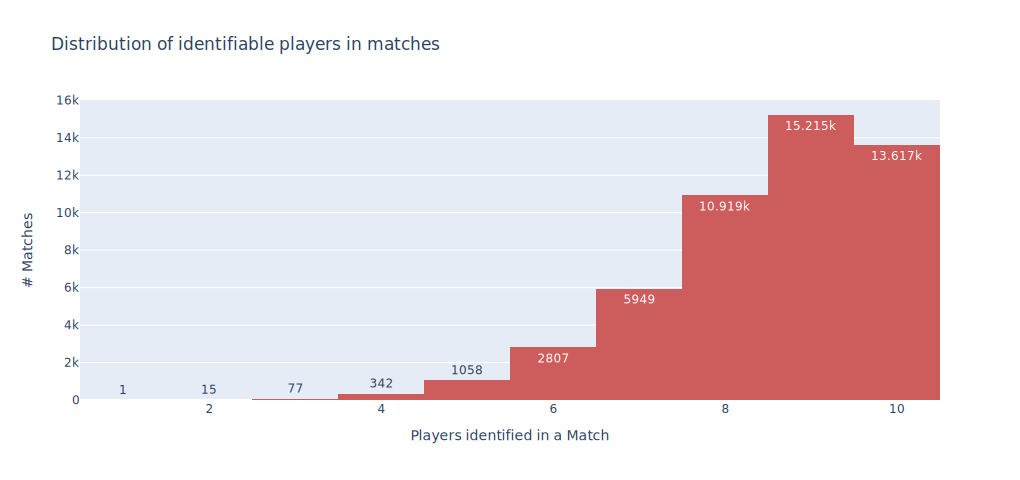

<Figure size 640x480 with 0 Axes>

In [79]:
# Plotting the total real account ID distribution per match
plt.figure()
fig = px.histogram(df['players'].groupby('match_id')[['account_id']].count(), nbins=10,
                   title='Distribution of identifiable players in matches', 
                   text_auto=True, color_discrete_sequence=['indianred'], width=1020, height=480)
fig.update_layout(showlegend=False, xaxis_title='Players identified in a Match', yaxis_title='# Matches')
fig.show('svg')

#### Filling Missing Values

In [80]:
# Checking for null values
df['players'].isna().sum().sort_values(ascending=False)\
[df['players'].isna().sum().sort_values(ascending=False) > 0 ]

unit_order_taunt                     425862
unit_order_continue                  425862
unit_order_set_item_combine_lock     425862
unit_order_radar                     425862
unit_order_vector_target_position    425862
unit_order_patrol                    425862
unit_order_none                      425857
unit_order_cast_rune                 425854
unit_order_move_to_direction         422362
unit_order_disassemble_item          412848
gold_abandon                         408667
unit_order_eject_item_from_stash     398011
unit_order_cast_toggle_auto          395134
unit_order_stop                      352991
gold_killing_couriers                342786
unit_order_cast_toggle               340340
unit_order_give_item                 331788
gold_buyback                         298282
unit_order_buyback                   297749
xp_roshan                            268629
unit_order_drop_item                 241461
unit_order_glyph                     233650
unit_order_pickup_item          

In [81]:
# Getting the features that are 100% null values
df['players'].isna().sum().sort_values(ascending=False)\
[(df['players'].isna().sum().sort_values(ascending=False) / df['players'].shape[0]) == 1]

unit_order_taunt                     425862
unit_order_continue                  425862
unit_order_set_item_combine_lock     425862
unit_order_radar                     425862
unit_order_vector_target_position    425862
unit_order_patrol                    425862
dtype: int64

Since these features do not provide any value, it is best to drop them before proceeding.

In [82]:
# Dropping features with all null values
df['players'].drop(columns=['unit_order_taunt', 'unit_order_continue', 
                            'unit_order_set_item_combine_lock', 
                            'unit_order_radar', 'unit_order_vector_target_position',
                            'unit_order_patrol'], inplace=True)

# Checking for null values
df['players'].isna().sum().sort_values(ascending=False)\
[df['players'].isna().sum().sort_values(ascending=False) > 0 ]

unit_order_none                     425857
unit_order_cast_rune                425854
unit_order_move_to_direction        422362
unit_order_disassemble_item         412848
gold_abandon                        408667
unit_order_eject_item_from_stash    398011
unit_order_cast_toggle_auto         395134
unit_order_stop                     352991
gold_killing_couriers               342786
unit_order_cast_toggle              340340
unit_order_give_item                331788
gold_buyback                        298282
unit_order_buyback                  297749
xp_roshan                           268629
unit_order_drop_item                241461
unit_order_glyph                    233650
unit_order_pickup_item              202367
gold_killing_roshan                 200328
stuns                               129055
unit_order_ping_ability             127837
account                             121968
messages_sent                       121953
unit_order_hold_position            105838
unit_order_

Before trying to remove any more features from the list, we should understand the meaning behind so many null values. My assumption is that most of these features are certain milestones that a player can optionally achieve during each match, therefore if they don't complete those milestones, instead of having a value of `0`, they were assigned a null value.

Let's explore each to see if there are any observations where there might be any `0` values.

In [83]:
# Saving all the columns with null values
nan_values = []
for column, series in (df['players'].isna().sum().sort_values(ascending=False)\
[df['players'].isna().sum().sort_values(ascending=False) > 0 ]).items():
    nan_values.append(column)

# Removing account since we don't want to fill missing values with 0
nan_values.remove('account')

# Iterating through all of our features containing null values
for column in nan_values:
    if (df['players'][column] == 0).any().any():
        print(f'Value 0 was found within the {column} column')

Value 0 was found within the gold_other column


Since there was only one column found, let's take a look at the observations with a 0 value in `gold_other`:

In [84]:
df['players'][df['players']['gold_other'] == 0]

,match_id,match_outcome,account,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,messages_sent,time_played,cluster
8530,853,0,NaN,4571,67,0,853_0,311,9570,413,390,6,8,12,12,128,NaN,10831,0,218,26,212,137,11,63,46,14,0,4055.0,6884.0,NaN,125.0,0.0,-2242.0,-484.0,NaN,100.0,556.0,3339.0,4892.0,NaN,NaN,NaN,2290.0,1.0,26.0,586.0,31.0,21.0,15.0,102.0,2.0,100.0,14.0,1.0,1.0,1.0,2.0,21.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1701,132
10812,1081,0,NaN,3351,30,2,1081_2,587,6115,197,213,2,9,6,3,33,33.913700,5552,1293,45,29,0,36,254,60,46,11,0,2812.0,4514.0,596.0,87.0,0.0,-2091.0,NaN,NaN,NaN,480.0,1790.0,1098.0,200.0,NaN,NaN,4884.0,123.0,89.0,237.0,28.0,43.0,5.0,29.0,47.0,241.0,12.0,NaN,NaN,NaN,NaN,27.0,NaN,NaN,7.0,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,2252,171
11907,1190,1,`monique,6193,21,130,1190_130,3939,21225,516,606,22,11,24,4,151,109.492000,31227,0,6842,152,50,1,168,108,48,25,0,21274.0,9461.0,1490.0,193.0,0.0,-5629.0,-1581.0,NaN,2454.0,4722.0,10297.0,6063.0,1092.0,NaN,NaN,4264.0,129.0,22.0,252.0,95.0,101.0,5.0,286.0,NaN,10.0,24.0,2.0,NaN,2.0,1.0,47.0,6.0,NaN,14.0,NaN,330.0,1.0,2.0,NaN,NaN,5.0,NaN,2.0,3207,133
22038,2203,0,치 ppp 치,11131,35,131,2203_131,1195,12745,425,431,7,11,11,12,163,0.066875,12491,0,0,166,63,154,0,0,172,17,0,5929.0,10181.0,NaN,112.0,0.0,-2779.0,-1768.0,NaN,1085.0,160.0,5126.0,6706.0,NaN,150.0,NaN,3613.0,NaN,66.0,827.0,43.0,15.0,3.0,83.0,NaN,36.0,17.0,NaN,NaN,NaN,6.0,36.0,7.0,NaN,9.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,3.0,2256,191
35243,3524,0,PaTaPi4*,17696,8,3,3524_3,1465,9800,372,358,4,8,5,6,152,NaN,8028,0,869,50,212,147,172,0,0,14,0,2152.0,9556.0,NaN,124.0,0.0,-2212.0,NaN,NaN,112.0,766.0,1527.0,6598.0,NaN,NaN,NaN,3388.0,82.0,NaN,481.0,18.0,9.0,2.0,72.0,5.0,NaN,14.0,NaN,NaN,NaN,4.0,23.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1977,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486814,48681,0,NaN,137027,112,4,48681_4,506,8305,189,111,3,10,5,0,27,69.388500,3556,0,99,102,29,0,254,36,73,9,0,1520.0,3571.0,NaN,80.0,0.0,-1910.0,NaN,NaN,262.0,1385.0,1574.0,891.0,200.0,NaN,NaN,4803.0,67.0,38.0,362.0,21.0,135.0,7.0,58.0,NaN,122.0,9.0,3.0,1.0,5.0,3.0,38.0,1.0,NaN,8.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,2770,122
493343,49334,1,plov,25298,36,3,49334_3,3146,20170,611,672,12,1,8,17,256,8.670310,12743,1266,2090,204,1,119,0,65,63,21,0,7965.0,15828.0,357.0,160.0,0.0,-359.0,NaN,NaN,832.0,3379.0,4702.0,9921.0,400.0,NaN,NaN,7382.0,NaN,30.0,1712.0,55.0,33.0,4.0,265.0,NaN,18.0,22.0,1.0,NaN,6.0,7.0,36.0,2.0,NaN,18.0,NaN,252.0,NaN,1.0,NaN,NaN,NaN,NaN,47.0,2169,138
495762,49576,0,NaN,157498,95,2,49576_2,256,11945,349,411,6,6,9,1,127,4.666170,9616,0,1319,212,116,50,164,7,7,16,0,4790.0,10221.0,NaN,137.0,0.0,-2394.0,NaN,NaN,75.0,847.0,2737.0,5523.0,NaN,NaN

It is safe to assume that the rest of the null values (except for `account`) can be filled with a 0.

In [85]:
# Filling NaN values
for column in nan_values:
    df['players'][column] = df['players'][column].fillna(0)

# Checking for null values
display(df['players'].isna().sum().sort_values(ascending=False)\
        [df['players'].isna().sum().sort_values(ascending=False) > 0 ])

# Sanity check
display(df['players'].isna().sum().sort_values(ascending=False)\
[df['players'].isna().sum().sort_values(ascending=False) > 0 ])
print('-----------------------------------------------------------------------')
display(df['players'].sample(5))

account    121968
dtype: int64

account    121968
dtype: int64

-----------------------------------------------------------------------


,match_id,match_outcome,account,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,messages_sent,time_played,cluster
216505,21650,0,LastYear,35553,80,128,21650_128,3076,12540,494,513,4,5,0,14,218,0.000000,7854,0,935,0,214,65,0,0,0,17,0,1296.0,15230.0,0.0,259.0,106.0,-1585.0,0.0,0.0,46.0,797.0,1602.0,10168.0,200.0,0.0,0.0,3922.0,69.0,43.0,436.0,5.0,14.0,2.0,139.0,0.0,149.0,18.0,0.0,3.0,0.0,1.0,20.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1957,138
126897,12689,1,shoKsi,0,67,130,12689_130,1839,26885,546,524,16,10,31,9,322,0.133750,33756,1479,4013,196,135,48,114,137,0,25,0,16416.0,15608.0,447.0,44.0,16.0,-5090.0,-3739.0,0.0,1524.0,4402.0,10390.0,12107.0,784.0,0.0,0.0,4784.0,4.0,13.0,1500.0,68.0,79.0,9.0,64.0,0.0,138.0,26.0,2.0,2.0,5.0,7.0,46.0,5.0,0.0,25.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,3722,132
167613,16761,1,NaN,43870,31,3,16761_3,1317,11610,306,327,4,9,11,2,72,0.600732,9892,1831,613,29,102,79,92,254,37,17,0,6155.0,8434.0,0.0,1329.0,0.0,-2631.0,0.0,0.0,15.0,3324.0,3654.0,2850.0,200.0,0.0,0.0,2798.0,3.0,4.0,424.0,16.0,202.0,2.0,37.0,0.0,0.0,17.0,1.0,1.0,1.0,1.0,41.0,1.0,0.0,4.0,0.0,172.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2918,133
425908,42590,0,Sugy,13084,55,131,42590_131,2123,11450,332,407,5,8,19,0,158,16.527100,11704,4472,108,178,231,108,0,0,0,19,0,9215.0,10184.0,447.0,323.0,127.0,-3592.0,-6.0,0.0,96.0,600.0,4316.0,6279.0,200.0,0.0,0.0,6010.0,178.0,0.0,314.0,46.0,174.0,1.0,46.0,0.0,0.0,18.0,1.0,0.0,1.0,7.0,32.0,2.0,0.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,4.0,2968,192
273751,27375,1,NaN,102018,11,1,27375_1,2212,26760,733,736,16,2,10,5,313,27.763200,16432,0,4504,63,133,1,116,164,154,22,0,7934.0,16337.0,894.0,502.0,302.0,-598.0,0.0,0.0,2949.0,4549.0,5504.0,11177.0,200.0,350.0,0.0,3636.0,0.0,0.0,1150.0,75.0,27.0,3.0,755.0,0.0,177.0,22.0,2.0,3.0,1.0,27.0,45.0,7.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2090,187


We have filled in all the missing values in our data frame, except for the accounts. Let's examine our `account` column.

In [86]:
# Since this is an object type, let's look if there are any accounts with a '0' value
df['players'][df['players']['account'] == '0']

,match_id,match_outcome,account,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,messages_sent,time_played,cluster
83679,8367,0,0,38677,73,132,8367_132,224,9985,331,244,0,3,2,1,81,6.73174,1850,385,293,178,79,0,152,63,43,11,0,548.0,6601.0,0.0,25.0,1234.0,-777.0,0.0,1278.0,625.0,400.0,254.0,3227.0,0.0,0.0,0.0,2944.0,64.0,39.0,379.0,50.0,7.0,4.0,46.0,0.0,217.0,11.0,0.0,0.0,0.0,1.0,35.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1762,171
101652,10165,1,0,45571,102,2,10165_2,4574,9540,418,416,7,6,13,3,40,0.00000,5849,4831,1220,231,36,81,46,0,0,16,0,9042.0,5093.0,447.0,82.0,0.0,-1404.0,0.0,0.0,100.0,4197.0,5246.0,1553.0,200.0,0.0,0.0,5612.0,2.0,1.0,1237.0,10.0,106.0,6.0,21.0,0.0,394.0,15.0,0.0,0.0,2.0,29.0,37.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2111,153
129805,12980,0,0,56186,106,128,12980_128,251,19295,484,666,7,7,11,10,260,0.00000,13957,0,187,145,0,41,141,141,48,24,0,16297.0,15303.0,0.0,374.0,289.0,-3413.0,-1565.0,0.0,100.0,702.0,7849.0,9384.0,200.0,0.0,0.0,8815.0,302.0,25.0,758.0,307.0,2.0,5.0,310.0,0.0,41.0,24.0,1.0,0.0,10.0,11.0,22.0,1.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,5.0,2878,133
151164,15116,0,0,62963,69,4,15116_4,1900,10725,382,326,4,6,2,2,68,11.08620,6933,0,0,1,65,108,181,214,46,14,0,2549.0,8102.0,0.0,665.0,2468.0,-1404.0,0.0,0.0,133.0,940.0,2073.0,4302.0,0.0,0.0,0.0,4697.0,79.0,0.0,336.0,32.0,65.0,3.0,36.0,0.0,0.0,14.0,0.0,0.0,3.0,6.0,22.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2079,111
229600,22960,1,0,0,70,0,22960_0,2040,13465,637,544,19,2,13,8,75,9.13218,21705,612,2214,50,1,208,181,81,182,15,0,5346.0,5372.0,1789.0,383.0,231.0,-238.0,0.0,0.0,0.0,3120.0,5662.0,3291.0,405.0,0.0,0.0,3191.0,132.0,81.0,639.0,16.0,1.0,5.0,335.0,0.0,0.0,15.0,0.0,0.0,3.0,10.0,21.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1419,204
285650,28565,1,0,32993,46,0,28565_0,5341,13835,757,739,10,2,2,14,185,0.00000,13874,0,3973,63,41,147,55,212,168,18,0,4600.0,11856.0,1789.0,617.0,301.0,-838.0,0.0,0.0,50.0,4646.0,3488.0,7959.0,392.0,0.0,0.0,2843.0,72.0,33.0,904.0,29.0,1.0,3.0,261.0,0.0,257.0,17.0,2.0,2.0,5.0,12.0,23.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1531,112
322627,32262,0,0,0,105,130,32262_130,2642,7475,280,328,3,12,13,1,98,2.50854,11353,0,114,29,1,41,0,23,21,17,0,7271.0,8041.0,0.0,105.0,62.0,-3378.0,-1016.0,0.0,400.0,680.0,3979.0,3736.0,0.0,0.0,0.0,5190.0,96.0,30.0,179.0,195.0,11.0,4.0,90.0,0.0,0.0,16.0,1.0,0.0,0.0,3.0,26.0,1.0,0.0,6.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,2813,204
438286,43828,0,0,10210,28,129,43828_129,237,11325,295,403,5,12,12,11,149,70.66170,7871,0,6,8,116,1,36,63,0,21,0,8834.0,13631.0,447.0,761.0,484.0,-5718.0,-336.0,0.0,400.0,680.0,4067.0,6041.0,200.0,0.0,0.0,4939.0,138.0,1.0,1208.0,66.0,38.0,4.0,270.0,0.0,228.0,21.0,0.0,0.0,2.0,51.0,28.0,2.0,0.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0,1.0,3516,151


It seems that some values with a `0` value were filtered from the chat and do not match their account ID. Let's replace them with a null value to later replace them with their corresponding account ID.

In [87]:
# Replacing '0' values with NaN
df['players']['account'] = df['players']['account'].replace('0', np.nan)

# Sanity Check
df['players'][df['players']['account'] == '0']

,match_id,match_outcome,account,account_id,hero_id,player_slot,match_slot_id,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,messages_sent,time_played,cluster


Now we're ready to replace the null values with their account IDs.

In [88]:
# Finding the null accounts with an account ID
mask = (df['players']['account'].isna()) & (df['players']['account_id'] != 0)

# Replacing the null values with the account number as a string
df['players'].loc[mask, 'account'] = df['players'].loc[mask, 'account_id'].astype(str)

# Sanity Check
df['players'][df['players']['account'].isna()][['account_id']]

,account_id
229600,0
322627,0


Let's remove the rows of the two players who couldn't be identified from our previous attempts.

In [89]:
# Dropping the rows from above
df['players'].drop([229600, 322627], axis=0, inplace=True)

# Sanity Check
df['players'][df['players']['account'].isna()][['account_id']]

,account_id


We have various methods to identify players, so we will keep this column as it is. Next, we need to determine if these features can be converted to integers, as pandas automatically converts numerical columns with null values as floats.

In [90]:
# Getting all the columns that may have true float values
float_columns = df['players'].select_dtypes(include='float').columns

def is_integer_series(series):
    # Check if all non-null values are integers
    return np.all(series.dropna().apply(lambda x: float(x).is_integer()))

for col in float_columns:
    if is_integer_series(df['players'][col]):
        df['players'][col] = df['players'][col].astype(np.int64)
    else:
        print(f'{col} holds real float numbers')

# Sanity check
df['players'].select_dtypes(include='float').columns

stuns holds real float numbers


Index(['stuns'], dtype='object')

After handling the missing values and ensuring the correct data types, we can now proceed with exploring the next file.

#### Exporting & Maintenance

In [91]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'players.csv')
df['players'].to_csv(file_path)

# Removing the file from memory
del df['players'], anonym_accounts, anonym_match_ids, player_ids, nan_values, matches, match_outcome, chat, chat_per_player, float_columns
gc.collect()

184

### Player Time

In [92]:
# Loading up the player_time.csv file
read_file('player_time.csv')

../Data/Raw/player_time.csv: 2,209,778 observations, 32 features


#### DataFrame Overview

In [93]:
# Overview of the DataFrame
df['player_time'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209778 entries, 0 to 2209777
Data columns (total 32 columns):
 #   Column      Dtype
---  ------      -----
 0   match_id    int64
 1   times       int64
 2   gold_t_0    int64
 3   lh_t_0      int64
 4   xp_t_0      int64
 5   gold_t_1    int64
 6   lh_t_1      int64
 7   xp_t_1      int64
 8   gold_t_2    int64
 9   lh_t_2      int64
 10  xp_t_2      int64
 11  gold_t_3    int64
 12  lh_t_3      int64
 13  xp_t_3      int64
 14  gold_t_4    int64
 15  lh_t_4      int64
 16  xp_t_4      int64
 17  gold_t_128  int64
 18  lh_t_128    int64
 19  xp_t_128    int64
 20  gold_t_129  int64
 21  lh_t_129    int64
 22  xp_t_129    int64
 23  gold_t_130  int64
 24  lh_t_130    int64
 25  xp_t_130    int64
 26  gold_t_131  int64
 27  lh_t_131    int64
 28  xp_t_131    int64
 29  gold_t_132  int64
 30  lh_t_132    int64
 31  xp_t_132    int64
dtypes: int64(32)
memory usage: 539.5 MB


In [94]:
# Looking at the DataFrame
df['player_time'].sample(20)

,match_id,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,xp_t_2,gold_t_3,lh_t_3,xp_t_3,gold_t_4,lh_t_4,xp_t_4,gold_t_128,lh_t_128,xp_t_128,gold_t_129,lh_t_129,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
1930665,43702,1800,14973,246,17944,8653,45,9709,9410,61,9087,6730,29,7088,11645,124,14111,7399,39,9357,16270,188,19093,15168,158,15339,8541,37,8399,7795,34,8327
445586,10094,3720,22540,274,28561,15212,40,21690,34306,367,32910,13947,69,16825,27476,406,32480,22173,99,30896,36194,459,32414,19797,80,20080,38132,456,32414,19753,102,30852
2168261,49062,2280,16937,108,23664,15328,112,18873,15236,62,18936,9249,27,8689,20767,173,28164,14743,58,22080,14134,147,17855,13428,116,15702,9258,12,10535,8069,38,8157
1316385,29824,2580,13516,85,18196,23179,256,25562,25013,212,21036,18641,120,25908,15612,130,17283,19891,301,24037,14706,25,16756,17562,116,21143,21201,214,28278,13210,45,17366
144803,3257,1860,14040,168,15814,16649,118,17634,9405,39,9948,8208,39,9729,10305,46,11618,7706,29,8382,10522,104,12125,7977,74,7385,11869,58,15295,7594,18,7213
2199312,49765,840,3673,18,3675,3211,30,2754,2096,9,2226,3399,46,4405,7650,87,5672,5018,86,5042,4773,46,4808,5300,56,5776,2345,7,2371,2459,4,2814
1983310,44891,600,3474,34,3315,2217,17,2865,2278,11,2270,1862,7,2748,2936,29,2360,2071,21,2062,2835,29,2124,3264,30,3828,3467,46,3477,2563,21,2553
1885703,42674,2100,11682,65,14465,11539,94,11445,11366,66,13324,14792,95,19064,15924,238,17928,13223,156,15557,8926,43,9510,18795,205,18309,13876,123,16349,11248,70,12795
1412518,31979,1140,7566,82,8118,4918,16,4855,6737,86,8020,4881,23,5299,5706,29,6261,5376,39,6909,7387,91,7055,7192,48,9562,3625,5,4147,6219,76,6565
2194871,49663,2700,16315,138,21285,14574,70,19273,14251,138,19015,21078,93,23741,22167,296,27958,17325,215,22922,22772,273,29300,14341,61,18957,24792,342,32530,12595,38,16559


#### Understanding the Values

This file contains the full match breakdown by player per minute, as per the initial notes. To understand the table easily, you can pick a random match and visualize it in a histogram.

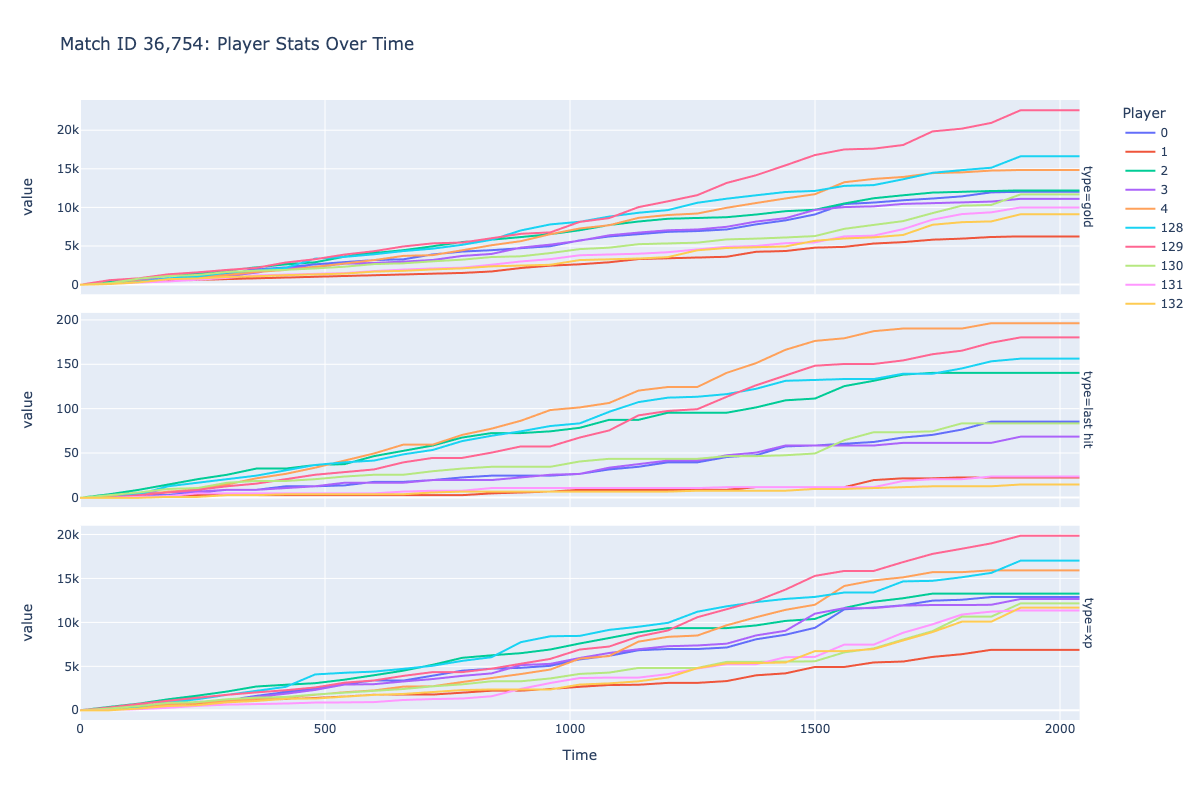

In [95]:
# Selecting a random match
random_match = df['player_time'][df['player_time']['match_id'] == 36754].drop(columns='match_id')

# Grouping columns by metric type
gold_cols = ['gold_t_0', 'gold_t_1', 'gold_t_2', 'gold_t_3', 'gold_t_4',
             'gold_t_128', 'gold_t_129', 'gold_t_130', 'gold_t_131', 'gold_t_132']

lh_cols = ['lh_t_0', 'lh_t_1', 'lh_t_2', 'lh_t_3', 'lh_t_4',
           'lh_t_128', 'lh_t_129', 'lh_t_130', 'lh_t_131', 'lh_t_132']

xp_cols = ['xp_t_0', 'xp_t_1', 'xp_t_2', 'xp_t_3', 'xp_t_4',
           'xp_t_128', 'xp_t_129', 'xp_t_130', 'xp_t_131', 'xp_t_132']

# Melting the random match for easier plotting
random_match = random_match.melt(id_vars=['times'],
                                 value_vars=gold_cols + lh_cols + xp_cols,
                                 var_name='player_metric',
                                 value_name='value')

# Adding a new column to indicate the type
random_match['type'] = random_match['player_metric'].apply(
    lambda x: 'gold' if 'gold' in x else ('last hit' if 'lh' in x else 'xp')
)

# Adding a new column to indicate the player slot
random_match['player_slot'] = random_match['player_metric'].apply(
    lambda x: 128 if '_128' in x else (129 if '_129' in x else (130 if '_130' in x else 
                                                                (131 if '_131' in x else (132 if '_132' in x else (
        0 if '_0' in x else (1 if '_1' in x else (2 if '_2' in x else (3 if '_3' in x else 4))))))))
)

# Visualizing the results
fig = px.line(random_match, 
              x='times', 
              y='value', 
              color='player_slot', 
              facet_row='type',
              labels={'player_slot': 'Player', 'times': 'Time'},
              title='Match ID 36,754: Player Stats Over Time')
fig.update_xaxes()
fig.update_yaxes(matches=None)
fig.update_layout(height=800, width=1200)
fig.show('png')

#### Duplicated Observations

In [96]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['player_time'].duplicated().sum(),
                                           round((df['player_time'].duplicated().sum()/df['player_time'].shape[0])*100,2)))

Duplicated rows: 0 (0.0)%


#### Filling Missing Values

In [97]:
# Checking for null values
df['player_time'].isna().sum()

match_id      0
times         0
gold_t_0      0
lh_t_0        0
xp_t_0        0
gold_t_1      0
lh_t_1        0
xp_t_1        0
gold_t_2      0
lh_t_2        0
xp_t_2        0
gold_t_3      0
lh_t_3        0
xp_t_3        0
gold_t_4      0
lh_t_4        0
xp_t_4        0
gold_t_128    0
lh_t_128      0
xp_t_128      0
gold_t_129    0
lh_t_129      0
xp_t_129      0
gold_t_130    0
lh_t_130      0
xp_t_130      0
gold_t_131    0
lh_t_131      0
xp_t_131      0
gold_t_132    0
lh_t_132      0
xp_t_132      0
dtype: int64

#### Exporting & Maintenance

While we could melt the DataFrame to make it easier for visualization purposes, it might be best to leave it as it is. However, we can define a function that we can export to other notebooks if we need to visualize the data from this file again.

In [98]:
# Defining a function to melt the data in player_time.csv
def melt_player_time(DataFrame):
    '''
    This is a visualization tool for the player_time.csv file, where after you pass along a filtered DataFrame with the match ID
    of interest, it will generate the charts displaying all the player stats broken down by minute passed.

    Parameters
    ----------
    DataFrame: A DataFrame input
        DataFrame containing the filtered values you want to visualize
    
    Returns
    -------
    Line Plot: A line plot displaying the values passed along the DataFrame over time
    
    Examples
    --------
    >>>> DataFrame = df['player_time'][df['player_time']['match_id'] == 36754]

    >>>> corr_matrix = DataFrame.corr()
    >>>> mask = np.triu(corr_matrix)
        
    >>>> plt.figure(figsize=(width, height))
    >>>> sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
    >>>> plt.show()
    '''
    assert isinstance(DataFrame, pd.DataFrame), 'You must provide a DataFrame type'

    # Grouping columns by metric type
    gold_cols = ['gold_t_0', 'gold_t_1', 'gold_t_2', 'gold_t_3', 'gold_t_4',
                 'gold_t_128', 'gold_t_129', 'gold_t_130', 'gold_t_131', 'gold_t_132']

    lh_cols = ['lh_t_0', 'lh_t_1', 'lh_t_2', 'lh_t_3', 'lh_t_4',
               'lh_t_128', 'lh_t_129', 'lh_t_130', 'lh_t_131', 'lh_t_132']

    xp_cols = ['xp_t_0', 'xp_t_1', 'xp_t_2', 'xp_t_3', 'xp_t_4',
               'xp_t_128', 'xp_t_129', 'xp_t_130', 'xp_t_131', 'xp_t_132']

    # Melting the random match for easier plotting
    melted_player_time = DataFrame.melt(
        id_vars=['times'],
        value_vars=gold_cols + lh_cols + xp_cols,
        var_name='player_metric',
        value_name='value'
    )

    # Adding a new column to indicate the type
    melted_player_time['type'] = melted_player_time['player_metric'].apply(
        lambda x: 'gold' if 'gold' in x else ('last hit' if 'lh' in x else 'xp')
    )

    # Adding a new column to indicate the player slot
    melted_player_time['player_slot'] = melted_player_time['player_metric'].apply(
        lambda x: 128 if '_128' in x else (129 if '_129' in x else 
                                           (130 if '_130' in x else (131 if '_131' in x else (132 if '_132' in x else (
            0 if '_0' in x else (1 if '_1' in x else (2 if '_2' in x else (3 if '_3' in x else 4))))))))
    )
    return melted_player_time

In [99]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'player_time.csv')
df['player_time'].to_csv(file_path)

# Removing the file from memory
del df['player_time'], random_match, gold_cols, lh_cols, xp_cols, fig
gc.collect()

1908

### Objectives

In [100]:
# Loading up the objectives.csv file
read_file('objectives.csv')

../Data/Raw/objectives.csv: 1,173,396 observations, 9 features


#### DataFrame Overview

In [101]:
# Overview of the DataFrame
df['objectives'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173396 entries, 0 to 1173395
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   match_id  1173396 non-null  int64  
 1   key       269576 non-null   float64
 2   player1   1173396 non-null  int64  
 3   player2   1173396 non-null  int64  
 4   slot      826853 non-null   float64
 5   subtype   1173396 non-null  object 
 6   team      778755 non-null   float64
 7   time      1173396 non-null  int64  
 8   value     1173396 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 80.6+ MB


In [102]:
# Looking at the DataFrame
df['objectives'].sample(20)

,match_id,key,player1,player2,slot,subtype,team,time,value
736884,31448,256.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2790,256
945932,40316,NaN,6,-1,6.0,CHAT_MESSAGE_TOWER_KILL,3.0,1561,3
454716,19438,NaN,4,-1,4.0,CHAT_MESSAGE_TOWER_KILL,2.0,886,2
1134908,48373,NaN,3,-1,3.0,CHAT_MESSAGE_AEGIS,NaN,1384,0
622538,26570,NaN,1,-1,1.0,CHAT_MESSAGE_TOWER_DENY,80.0,1068,80
320129,13682,NaN,8,-1,8.0,CHAT_MESSAGE_TOWER_KILL,3.0,530,3
1139435,48559,NaN,5,-1,5.0,CHAT_MESSAGE_TOWER_KILL,3.0,2374,3
1090734,46492,NaN,-1,-1,-1.0,CHAT_MESSAGE_TOWER_KILL,2.0,1280,2
810432,34548,1.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,1894,1
544522,23257,NaN,3,-1,3.0,CHAT_MESSAGE_TOWER_KILL,2.0,2297,2


This file contains every notification where an objective was completed. From the looks of it, the -1 value displays the in-game actions *(i.e. when a team's creeps destroy a tower or when a player destroys some barracks)*.

In [103]:
# Checking the subtype values whenever the player 2 is not -1
df['objectives'][df['objectives']['player2'] != -1]['subtype'].unique()

array(['CHAT_MESSAGE_FIRSTBLOOD'], dtype=object)

The only time player 2 is not `-1` is when there is a first-blood *(first kill of the match)*, meaning that player 2 was the player killed during that encounter. 

Let's clean this file up to include only the notifications involving at least one player and remove the irrelevant features.

#### Data Formatting

##### Player1 & Player2

In [104]:
# Checking the unique values in player1
print('Unique values:', df['objectives']['player1'].nunique())
np.sort(df['objectives']['player1'].unique())

Unique values: 11


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [105]:
# Checking the unique values in player2
print('Unique values:', df['objectives']['player2'].nunique())
np.sort(df['objectives']['player2'].unique())

Unique values: 11


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [106]:
# Checking the rows with a player1 and player 2 value of -1
df['objectives'].loc[(df['objectives']['player1'] == -1) & (df['objectives']['player2'] == -1), :]

,match_id,key,player1,player2,slot,subtype,team,time,value
6,0,NaN,-1,-1,-1.0,CHAT_MESSAGE_TOWER_KILL,2.0,1446,2
10,0,NaN,-1,-1,-1.0,CHAT_MESSAGE_TOWER_KILL,2.0,1779,2
11,0,NaN,-1,-1,-1.0,CHAT_MESSAGE_TOWER_KILL,2.0,1901,2
13,0,4.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2098,4
14,0,8.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2103,8
...,...,...,...,...,...,...,...,...,...
1173385,49999,2048.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2358,2048
1173387,49999,256.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2532,256
1173388,49999,512.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2534,512
1173390,49999,128.0,-1,-1,NaN,CHAT_MESSAGE_BARRACKS_KILL,NaN,2554,128


In [107]:
# Removing all the interactions where no player was involved
df['objectives'] = df['objectives'][~((df['objectives']['player1'] == -1) & (df['objectives']['player2'] == -1))]
print('Unique values:', df['objectives']['player1'].nunique())
np.sort(df['objectives']['player1'].unique())

Unique values: 10


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Next, we need to convert those values the same way we did on the Chat DataFrame.

In [108]:
# Changing the player1 and player2 to the general convention
slot_5 = df['objectives']['player1'] == 5
df['objectives'].loc[slot_5,'player1'] = 128
slot_5 = df['objectives']['player2'] == 5
df['objectives'].loc[slot_5,'player2'] = 128

slot_6 = df['objectives']['player1'] == 6
df['objectives'].loc[slot_6,'player1'] = 129
slot_6 = df['objectives']['player2'] == 6
df['objectives'].loc[slot_6,'player2'] = 129

slot_7 = df['objectives']['player1'] == 7
df['objectives'].loc[slot_7,'player1'] = 130
slot_7 = df['objectives']['player2'] == 7
df['objectives'].loc[slot_7,'player2'] = 130

slot_8 = df['objectives']['player1'] == 8
df['objectives'].loc[slot_8,'player1'] = 131
slot_8 = df['objectives']['player2'] == 8
df['objectives'].loc[slot_8,'player2'] = 131

slot_9 = df['objectives']['player1'] == 9
df['objectives'].loc[slot_9,'player1'] = 132
slot_9 = df['objectives']['player2'] == 9
df['objectives'].loc[slot_9,'player2'] = 132

# Sanity Check
df['objectives'].sample(20)

,match_id,key,player1,player2,slot,subtype,team,time,value
283151,12095,NaN,1,-1,1.0,CHAT_MESSAGE_TOWER_KILL,2.0,794,2
337010,14400,NaN,132,4,9.0,CHAT_MESSAGE_FIRSTBLOOD,NaN,181,325
690254,29466,NaN,132,4,9.0,CHAT_MESSAGE_FIRSTBLOOD,NaN,182,385
977773,41675,NaN,130,-1,7.0,CHAT_MESSAGE_AEGIS,NaN,1925,0
739874,31578,NaN,131,-1,8.0,CHAT_MESSAGE_TOWER_KILL,3.0,2093,3
682462,29130,NaN,128,-1,5.0,CHAT_MESSAGE_TOWER_KILL,3.0,882,3
685053,29244,NaN,0,-1,0.0,CHAT_MESSAGE_TOWER_KILL,2.0,1001,2
364556,15563,NaN,129,-1,6.0,CHAT_MESSAGE_TOWER_KILL,3.0,1879,3
165873,7071,NaN,4,-1,4.0,CHAT_MESSAGE_TOWER_KILL,2.0,1081,2
975052,41562,NaN,130,-1,7.0,CHAT_MESSAGE_TOWER_KILL,3.0,1222,3


##### Key

In [109]:
# Checking the unique values in key
print('Unique values:', df['objectives']['key'].nunique())
np.sort(df['objectives']['key'].unique())

Unique values: 0


array([nan])

In [110]:
# Dropping the key column
df['objectives'].drop(columns='key', inplace=True)
df['objectives'].sample(10)

,match_id,player1,player2,slot,subtype,team,time,value
991729,42261,3,-1,3.0,CHAT_MESSAGE_TOWER_KILL,2.0,1988,2
530603,22670,2,-1,2.0,CHAT_MESSAGE_TOWER_KILL,2.0,2261,2
502004,21454,128,-1,5.0,CHAT_MESSAGE_TOWER_KILL,3.0,3715,3
337883,14434,131,-1,8.0,CHAT_MESSAGE_TOWER_KILL,3.0,1656,3
494740,21139,128,-1,5.0,CHAT_MESSAGE_TOWER_KILL,3.0,3064,3
1127070,48039,129,-1,6.0,CHAT_MESSAGE_TOWER_KILL,3.0,1332,3
1042559,44436,131,-1,8.0,CHAT_MESSAGE_TOWER_KILL,3.0,1859,3
913590,38949,3,129,3.0,CHAT_MESSAGE_FIRSTBLOOD,NaN,109,337
82043,3498,2,-1,NaN,CHAT_MESSAGE_ROSHAN_KILL,2.0,2199,200
28667,1207,1,-1,1.0,CHAT_MESSAGE_TOWER_KILL,2.0,1333,2


##### Slot

In [111]:
# Checking the unique values in slot
print('Unique values:', df['objectives']['slot'].nunique())
np.sort(df['objectives']['slot'].unique())

Unique values: 10


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

Since this contains the player slot that scored the objective, it can be replaced by Player1 entirely, therefore we can drop the column.

In [112]:
# Dropping the slot column
df['objectives'].drop(columns='slot', inplace=True)
df['objectives'].sample(10)

,match_id,player1,player2,subtype,team,time,value
387400,16537,3,-1,CHAT_MESSAGE_ROSHAN_KILL,3.0,2350,200
782546,33378,132,-1,CHAT_MESSAGE_TOWER_KILL,3.0,1514,3
861586,36733,1,-1,CHAT_MESSAGE_TOWER_KILL,2.0,685,2
401283,17138,2,-1,CHAT_MESSAGE_TOWER_KILL,2.0,2026,2
450127,19242,130,-1,CHAT_MESSAGE_TOWER_KILL,3.0,1234,3
108809,4644,130,-1,CHAT_MESSAGE_AEGIS,NaN,2158,0
225735,9622,129,-1,CHAT_MESSAGE_AEGIS,NaN,1941,0
494257,21118,3,-1,CHAT_MESSAGE_ROSHAN_KILL,3.0,1708,200
622556,26570,130,-1,CHAT_MESSAGE_TOWER_KILL,3.0,2328,3
951232,40551,0,-1,CHAT_MESSAGE_TOWER_DENY,80.0,1602,80


##### Team

In [113]:
# Checking the unique values in team
print('Unique values:', df['objectives']['team'].nunique())
np.sort(df['objectives']['team'].unique())

Unique values: 6


array([  2.,   3.,  80., 100., 120., 140.,  nan])

These values don't represent any relevant information for the scope of the project, therefore we can drop this column as well.

In [114]:
# Dropping the team column
df['objectives'].drop(columns='team', inplace=True)
df['objectives'].sample(10)

,match_id,player1,player2,subtype,time,value
1020880,43516,132,3,CHAT_MESSAGE_FIRSTBLOOD,166,411
1044947,44538,129,-1,CHAT_MESSAGE_TOWER_KILL,565,3
587047,25065,4,-1,CHAT_MESSAGE_TOWER_KILL,2341,2
357369,15259,2,-1,CHAT_MESSAGE_TOWER_DENY,1320,80
183133,7803,128,-1,CHAT_MESSAGE_TOWER_KILL,815,3
384337,16406,4,-1,CHAT_MESSAGE_AEGIS,1654,0
222387,9477,1,-1,CHAT_MESSAGE_TOWER_KILL,1966,2
314153,13426,130,-1,CHAT_MESSAGE_TOWER_KILL,1052,3
869307,37064,132,-1,CHAT_MESSAGE_TOWER_KILL,1186,3
1112413,47416,2,-1,CHAT_MESSAGE_TOWER_KILL,1493,2


#### Filling Missing Values

In [115]:
# Checking for null values
df['objectives'].isna().sum()

match_id    0
player1     0
player2     0
subtype     0
time        0
value       0
dtype: int64

#### Export & Maintenance

In [116]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'objectives.csv')
df['objectives'].to_csv(file_path)

# Removing the file from memory
del df['objectives'], slot_5, slot_6, slot_7, slot_8, slot_9
gc.collect()

0

### Ability Upgrades

In [117]:
# Loading up the ability_upgrades.csv file
read_file('ability_upgrades.csv')

../Data/Raw/ability_upgrades.csv: 8,939,599 observations, 5 features


#### DataFrame Overview

In [118]:
# Overview of the DataFrame
df['ability_upgrades'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8939599 entries, 0 to 8939598
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   ability      int64
 1   level        int64
 2   time         int64
 3   player_slot  int64
 4   match_id     int64
dtypes: int64(5)
memory usage: 341.0 MB


In [119]:
# Looking at the DataFrame
df['ability_upgrades'].sample(20)

,ability,level,time,player_slot,match_id
3703204,5100,4,624,3,20736
6513594,5353,10,1353,132,36427
2863490,5249,4,779,0,16028
5947949,5002,23,2932,131,33264
3615390,5002,15,2280,130,20245
1005171,5132,2,458,3,5620
2078741,5002,17,3236,3,11659
5317089,5625,3,511,132,29755
6183666,5353,8,1380,129,34579
5307085,5002,25,3886,131,29700


#### Duplicated Observations

In [120]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['ability_upgrades'].duplicated().sum(),
                                           round((df['ability_upgrades'].duplicated().sum()/df['ability_upgrades'].shape[0])*100,2)))

Duplicated rows: 0 (0.0)%


#### Filling Missing Values

In [121]:
# Checking for null values
df['ability_upgrades'].isna().sum()

ability        0
level          0
time           0
player_slot    0
match_id       0
dtype: int64

#### Export & Maintenance

This file was spotless and straight-forward. It's best to keep it as it is and save it to our clean directory.

In [122]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'ability_upgrades.csv')
df['ability_upgrades'].to_csv(file_path)

# Removing the file from memory
del df['ability_upgrades']
gc.collect()

0

### Purchase Log

In [123]:
# Loading up the purchase_log.csv file
read_file('purchase_log.csv')

../Data/Raw/purchase_log.csv: 18,193,745 observations, 4 features


#### DataFrame Overview

In [124]:
# Overview of the DataFrame
df['purchase_log'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18193745 entries, 0 to 18193744
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   item_id      int64
 1   time         int64
 2   player_slot  int64
 3   match_id     int64
dtypes: int64(4)
memory usage: 555.2 MB


In [125]:
# Looking at the DataFrame
df['purchase_log'].sample(20)

,item_id,time,player_slot,match_id
12331789,28,134,3,33916
7988821,46,2839,129,21995
11335378,46,1979,132,31176
512738,108,1357,1,1399
757797,46,889,131,2071
10071230,21,2192,131,27709
6396967,27,2260,130,17605
17587415,12,-73,2,48334
12792126,43,2251,131,35174
16904264,46,559,131,46460


#### Duplicated Observations

In [126]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['purchase_log'].duplicated().sum(),
                                           round((df['purchase_log'].duplicated().sum()/df['purchase_log'].shape[0])*100,2)))

Duplicated rows: 869,231 (4.78)%


In [127]:
# Getting a quick look at the duplicated rows
print('Unique values:', df['purchase_log'][df['purchase_log'].duplicated()]['item_id'].nunique())
print(np.sort(df['purchase_log'][df['purchase_log'].duplicated()]['item_id'].unique()))

df['purchase_log'][df['purchase_log'].duplicated()].sort_values(['match_id', 'time']).head(20)

Unique values: 103
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  31  32  34  36  37  38  39
  40  41  42  43  44  46  48  50  51  53  54  55  56  57  58  59  60  61
  63  65  67  69  71  73  75  77  79  81  86  88  92  94 100 102 104 106
 108 114 116 127 133 141 143 145 149 151 152 154 162 164 168 170 172 178
 181 182 185 187 188 190 206 212 214 215 216 218 247]


,item_id,time,player_slot,match_id
72,42,-84,2,0
317,42,-73,131,0
286,16,-69,130,0
104,16,-64,3,0
158,14,91,4,0
78,42,335,2,0
163,13,337,4,0
167,16,408,4,0
250,2,501,129,0
329,42,637,131,0


While some duplicates seem arbitrary, we can assume that a player might have bought more than one copy of the same value in the exact second. We won't be removing them, but should be aware of this going forward.

#### Filling Missing Values

In [128]:
# Checking for null values
df['purchase_log'].isna().sum()

item_id        0
time           0
player_slot    0
match_id       0
dtype: int64

#### Export & Maintenance

In [129]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'purchase_log.csv')
df['purchase_log'].to_csv(file_path)

# Removing the file from memory
del df['purchase_log']
gc.collect()

0

### Teamfights

In [130]:
# Loading up the teamfights.csv file
read_file('teamfights.csv')

../Data/Raw/teamfights.csv: 539,047 observations, 5 features


#### DataFrame Overview

In [131]:
# Overview of the DataFrame
df['teamfights'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539047 entries, 0 to 539046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   match_id    539047 non-null  int64
 1   start       539047 non-null  int64
 2   end         539047 non-null  int64
 3   last_death  539047 non-null  int64
 4   deaths      539047 non-null  int64
dtypes: int64(5)
memory usage: 20.6 MB


In [132]:
# Looking at the DataFrame
df['teamfights'].head(20)

,match_id,start,end,last_death,deaths
0,0,220,252,237,3
1,0,429,475,460,3
2,0,900,936,921,3
3,0,1284,1328,1313,3
4,0,1614,1666,1651,5
5,0,1672,1709,1694,3
6,0,1734,1783,1768,6
7,0,1818,1867,1852,5
8,0,1863,1912,1897,5
9,0,2101,2145,2130,4


#### Data Formatting

Since multiple teamfights occur during a single match, it would be nice to know the order to get other significant stats.

In [133]:
# Inserting the teamfight order from each match
df['teamfights'].insert(1, 'tf_order', df['teamfights'].groupby('match_id').cumcount().add(1))
df['teamfights'].head(20)

,match_id,tf_order,start,end,last_death,deaths
0,0,1,220,252,237,3
1,0,2,429,475,460,3
2,0,3,900,936,921,3
3,0,4,1284,1328,1313,3
4,0,5,1614,1666,1651,5
5,0,6,1672,1709,1694,3
6,0,7,1734,1783,1768,6
7,0,8,1818,1867,1852,5
8,0,9,1863,1912,1897,5
9,0,10,2101,2145,2130,4


#### Duplicated Observations

In [134]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['teamfights'].duplicated().sum(),
                                           round((df['teamfights'].duplicated().sum()/df['teamfights'].shape[0])*100,2)))

Duplicated rows: 0 (0.0)%


#### Filling Missing Values

In [135]:
# Checking for null values
df['teamfights'].isna().sum()

match_id      0
tf_order      0
start         0
end           0
last_death    0
deaths        0
dtype: int64

#### Export

In [136]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'teamfights.csv')
df['teamfights'].to_csv(file_path)

### Teamfight Players

In [137]:
# Loading up the teamfights_players.csv file
read_file('teamfights_players.csv')

../Data/Raw/teamfights_players.csv: 5,390,470 observations, 8 features


#### DataFrame Overview

In [138]:
# Overview of the DataFrame
df['teamfights_players'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5390470 entries, 0 to 5390469
Data columns (total 8 columns):
 #   Column       Dtype
---  ------       -----
 0   match_id     int64
 1   player_slot  int64
 2   buybacks     int64
 3   damage       int64
 4   deaths       int64
 5   gold_delta   int64
 6   xp_end       int64
 7   xp_start     int64
dtypes: int64(8)
memory usage: 329.0 MB


In [139]:
# Looking at the DataFrame
df['teamfights_players'].sample(20)

,match_id,player_slot,buybacks,damage,deaths,gold_delta,xp_end,xp_start
8057,74,130,0,615,1,328,4922,3356
1262532,11732,2,0,309,0,1052,9189,7702
3067399,28383,132,0,0,0,514,8908,8397
2831781,26246,1,0,728,1,-509,16981,16904
2029037,18853,130,0,0,0,128,7195,6968
5109983,47372,3,0,238,0,84,3264,3069
5311179,49248,132,0,285,1,245,1690,1421
2524398,23409,131,0,326,1,-493,16932,16806
576031,5369,1,0,675,0,225,3757,3342
1172547,10911,130,0,0,0,78,3542,3360


#### Data Formatting

According to the notes from our files, we have a set of 10 *(one observation per player)* in the breakdown for each observation in the `df['teamfights']` DataFrame. Merging the two tables might help define a teamfight ID.

In [140]:
# First we need to know the total teamfights we have
print('Total teamfights: {:,}'.format(df['teamfights'].shape[0]))
print('Total observations in breakdown: {:,}'.format(df['teamfights_players'].shape[0]))
print('Teamfights have 10x observations:', df['teamfights'].shape[0] == (df['teamfights_players'].shape[0]/10))

Total teamfights: 539,047
Total observations in breakdown: 5,390,470
Teamfights have 10x observations: True


In [141]:
# Including the tf_id column in the detailed dataset
df['teamfights_players'].insert(1, 'tf_id', df['teamfights_players'].index // 10)
df['teamfights_players'].head(50)

,match_id,tf_id,player_slot,buybacks,damage,deaths,gold_delta,xp_end,xp_start
0,0,0,0,0,105,0,173,536,314
1,0,0,1,0,566,1,0,1583,1418
2,0,0,2,0,0,0,0,391,391
3,0,0,3,0,0,0,123,1775,1419
4,0,0,4,0,444,0,336,1267,983
5,0,0,128,0,477,1,249,1318,1035
6,0,0,129,0,636,1,-27,1048,904
7,0,0,130,0,0,0,190,1904,1589
8,0,0,131,0,0,0,0,210,210
9,0,0,132,0,0,0,378,659,589


#### Duplicated Observations

In [142]:
# Checking for any duplicated rows
print('Duplicated rows: {:,} ({})%'.format(df['teamfights_players'].duplicated().sum(),
                                           round((df['teamfights_players'].duplicated().sum()/
                                                  df['teamfights_players'].shape[0])*100,2)))

Duplicated rows: 0 (0.0)%


#### Filling Missing Values

In [143]:
# Checking for null values
df['teamfights_players'].isna().sum()

match_id       0
tf_id          0
player_slot    0
buybacks       0
damage         0
deaths         0
gold_delta     0
xp_end         0
xp_start       0
dtype: int64

#### Export & Maintenance

In [144]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'teamfights_players.csv')
df['teamfights_players'].to_csv(file_path)

# Removing the file from memory
del df['teamfights_players'], df['teamfights']
gc.collect()

0

---
## Referencial Data

In this section, we'll explore the files containing historical and referential information.

### Previous Outcomes

In [145]:
# Loading up the match_outcomes.csv file
read_file('match_outcomes.csv')

../Data/Raw/match_outcomes.csv: 1,828,588 observations, 10 features


In [146]:
# Overview of the DataFrame
df['match_outcomes'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828588 entries, 0 to 1828587
Data columns (total 10 columns):
 #   Column          Dtype
---  ------          -----
 0   match_id        int64
 1   account_id_0    int64
 2   account_id_1    int64
 3   account_id_2    int64
 4   account_id_3    int64
 5   account_id_4    int64
 6   start_time      int64
 7   parser_version  int64
 8   win             int64
 9   rad             int64
dtypes: int64(10)
memory usage: 139.5 MB


In [147]:
# Checking for null values
df['match_outcomes'].isna().sum()

match_id          0
account_id_0      0
account_id_1      0
account_id_2      0
account_id_3      0
account_id_4      0
start_time        0
parser_version    0
win               0
rad               0
dtype: int64

In [148]:
# Looking at the DataFrame
df['match_outcomes'].head(20)

,match_id,account_id_0,account_id_1,account_id_2,account_id_3,account_id_4,start_time,parser_version,win,rad
0,1636204962,34549,0,0,-51743434,-120875154,1437014585,12,1,0
1,1636204962,0,61598,138825,0,207232,1437014585,12,0,1
2,1636322679,0,-44943233,-240360907,19599,0,1437019968,12,0,0
3,1636322679,-97530201,0,0,0,-116349387,1437019968,12,1,1
4,1637385965,0,0,0,104738,0,1437052551,12,1,0
5,1637385965,0,0,278620,278619,0,1437052551,12,0,1
6,1637623870,-123447796,68408,-100048908,-16784805,320715,1437058007,12,1,0
7,1637623870,-108454938,-251819996,0,51172,-106710926,1437058007,12,0,1
8,1637739731,320093,0,178850,-45490226,-119392638,1437060903,12,0,0
9,1637739731,0,241925,-115963827,14072,-67386586,1437060903,12,1,1


By the looks of it, it seems that we can use this file to train potential matchmaking models with previous match ups and outcomes. However, we can clean it up by renaming the columns to follow the same format as other files, as well as merging rows with the same match ID and assigning the **Dire** team account IDs to their respective position column.

In [149]:
# Checking the unique values from parser_version
df['match_outcomes']['parser_version'].unique()

array([12, 13, 14])

In [150]:
# Separating Radiant from Dire accounts
radiant = df['match_outcomes'][df['match_outcomes']['rad'] == 1].copy()
dire = df['match_outcomes'][df['match_outcomes']['rad'] == 0].copy()

# Renaming the columns from Dire
dire.rename(columns={
    'account_id_0': 'account_id_128',
    'account_id_1': 'account_id_129',
    'account_id_2': 'account_id_130',
    'account_id_3': 'account_id_131',
    'account_id_4': 'account_id_132',
}, inplace=True)

# Dropping unnecessary columns
dire.drop(columns=['start_time', 'parser_version', 'win', 'rad'], inplace=True)
radiant.drop(columns='rad', inplace=True)

# Merging both DataFrames
df['match_outcomes'] = pd.merge(radiant, dire, on='match_id')

# Organizing and renaming columns
df['match_outcomes'].set_index('match_id', inplace=True)
df['match_outcomes'].rename(columns={'win': 'radiant_win'}, inplace=True)
df['match_outcomes'] = df['match_outcomes'][[
    'start_time', 'account_id_0', 'account_id_1', 'account_id_2', 'account_id_3', 'account_id_4', 'radiant_win',
    'account_id_128', 'account_id_129', 'account_id_130', 'account_id_131', 'account_id_132', 'parser_version'
]]

# Looking at the new DataFrame
df['match_outcomes'].head(20)

,start_time,account_id_0,account_id_1,account_id_2,account_id_3,account_id_4,radiant_win,account_id_128,account_id_129,account_id_130,account_id_131,account_id_132,parser_version
match_id,,,,,,,,,,,,,
1636204962,1437014585,0,61598,138825,0,207232,0,34549,0,0,-51743434,-120875154,12
1636322679,1437019968,-97530201,0,0,0,-116349387,1,0,-44943233,-240360907,19599,0,12
1637385965,1437052551,0,0,278620,278619,0,0,0,0,0,104738,0,12
1637623870,1437058007,-108454938,-251819996,0,51172,-106710926,0,-123447796,68408,-100048908,-16784805,320715,12
1637739731,1437060903,0,241925,-115963827,14072,-67386586,1,320093,0,178850,-45490226,-119392638,12
1637843670,1437063709,179628,7317,72598,-54120646,0,0,-142035,-63684257,72554,213175,-45490226,12
1637995977,1437068379,0,-232879514,112015,0,85776,1,0,53936,-116357051,-130700702,-110612461,12
1638064585,1437070692,-167470448,0,305550,83093,-192152053,0,103832,-94111546,0,-113340211,-112424993,12
1638095252,1437071741,0,-87947497,248282,-65305327,0,1,0,0,0,0,0,12


In [151]:
# Shape of the new DataFrame
df['match_outcomes'].shape

(914294, 13)

In [152]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'prev_outcomes.csv')
df['match_outcomes'].to_csv(file_path)

# Removing the file from memory
del df['match_outcomes'], radiant, dire
gc.collect()

0

### Player Ratings

In [153]:
# Loading up the player_ratings.csv file
read_file('player_ratings.csv', index=0)

../Data/Raw/player_ratings.csv: 834,226 observations, 4 features


In [154]:
# Overview of the DataFrame
df['player_ratings'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 834226 entries, 236579 to 0
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   total_wins       834226 non-null  int64  
 1   total_matches    834226 non-null  int64  
 2   trueskill_mu     834226 non-null  float64
 3   trueskill_sigma  834226 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 31.8 MB


In [155]:
# Checking for null values
df['player_ratings'].isna().sum()

total_wins         0
total_matches      0
trueskill_mu       0
trueskill_sigma    0
dtype: int64

In [156]:
# Looking at the DataFrame
df['player_ratings'].sample(20)

,total_wins,total_matches,trueskill_mu,trueskill_sigma
account_id,,,,
-91323966,3,5,26.972505,7.381665
-84423487,0,2,21.193965,7.869303
175370,24,52,27.016216,3.372484
-112862341,2,2,28.727733,7.740558
68380,3,6,25.638519,6.706091
-32625043,12,26,27.167994,4.842254
-115629592,0,1,23.533342,8.128313
327703,7,14,23.625515,5.895683
-201745224,1,1,27.124378,8.062445


According to **Devin Anzelmo**, this file contains **True Skill** rating for players in the match and test data. It was calculated from this [**Kaggle Kernel**](https://www.kaggle.com/code/devinanzelmo/dota-2-skill-rating-with-trueskill), using the [**TrueSkill**](https://trueskill.org/) library.

He also suggests using the following ranking formula to penalyze players with fewer matches to compensate for uncertainty:
<center>$\mu_{\text{TrueSkill}}  - 3\sigma_{\text{TrueSkill}}$</center>

In [157]:
# Adding the penalyzed ranking
df['player_ratings']['conservative_skill_estimate'] = df['player_ratings']['trueskill_mu'] - \
                                                       3 * df['player_ratings']['trueskill_sigma']
df['player_ratings'].head(20)

,total_wins,total_matches,trueskill_mu,trueskill_sigma,conservative_skill_estimate
account_id,,,,,
236579,14,24,27.868035,5.212361,12.230953
-343,1,1,26.544163,8.065475,2.347736
-1217,1,1,26.521103,8.114989,2.176136
-1227,1,1,27.248025,8.092217,2.971375
-1284,0,1,22.931016,8.092224,-1.345657
308663,1,1,26.761476,8.108880,2.434837
79749,21,40,30.553417,3.868734,18.947214
-1985,0,1,23.263409,8.098020,-1.030652
-2160,8,12,27.426018,6.391300,8.252117


This new DataFrame has the potential of becoming a target variable for our matchmaking modelling. Let's save it with a more descriptive name on our clean directory.

In [158]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'trueskill.csv')
df['player_ratings'].to_csv(file_path)

# Removing the file from memory
del df['player_ratings']
gc.collect()

0

### MMR

Looking into the source of the DataFrame, I discovered the [**OpenDota Core Repository**](https://github.com/odota/core/wiki/MMR-Data) from the original dump, where it was posted on their wiki page the file containing all the **Matchmaking Ratings** for all players sampled.

In [159]:
# Loading up the MMR.csv file
read_file('MMR.csv', index=0)

../Data/Raw/MMR.csv: 1,069,672 observations, 1 features


In [160]:
# Overview of the DataFrame
df['MMR'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1069672 entries, 103757918 to 93119769
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   MMR     1069672 non-null  int64
dtypes: int64(1)
memory usage: 16.3 MB


In [161]:
# Checking for null values
df['MMR'].isna().sum()

MMR    0
dtype: int64

In [162]:
# Looking at the DataFrame
df['MMR'].sample(20)

,MMR
account_id,
107980423,3823
138515507,3099
175947518,3562
95169248,2471
124563274,3714
145001168,4174
200323750,5120
197018761,1532
141242422,1017


Seems straight forward, however, there might be some slight diferences between ***True Skill*** and ***MMR***. I'll keep this file and eventually join both this and the trueskill file with the player data.

In [163]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'mmr.csv')
df['MMR'].to_csv(file_path)

# Removing the file from memory
del df['MMR']
gc.collect()

0

---
## Test Data

In this section, we'll explore the files starting with the label `test_`.

### Test Labels

In [164]:
# Loading up the test_labels.csv.csv file
read_file('test_labels.csv', index=0)

../Data/Raw/test_labels.csv: 100,000 observations, 1 features


In [165]:
# Overview of the DataFrame
df['test_labels'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 50000 to 149999
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   radiant_win  100000 non-null  int64
dtypes: int64(1)
memory usage: 1.5 MB


In [166]:
# Checking for null values
df['test_labels'].isna().sum()

radiant_win    0
dtype: int64

In [167]:
# Looking at the DataFrame
df['test_labels'].sample(20)

,radiant_win
match_id,
102570,1
60555,1
119944,1
137523,1
126560,1
77328,0
145506,1
116236,0
130478,1


I'll just rename this file to `test_outcomes` and move on.

In [168]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'test_outcomes.csv')
df['test_labels'].to_csv(file_path)

# Removing the file from memory
del df['test_labels']
gc.collect()

0

### Test Players

In [169]:
# Loading up the test_player.csv.csv file
read_file('test_player.csv')

../Data/Raw/test_player.csv: 1,000,000 observations, 4 features


In [170]:
# Overview of the DataFrame
df['test_player'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   match_id     1000000 non-null  int64
 1   account_id   1000000 non-null  int64
 2   hero_id      1000000 non-null  int64
 3   player_slot  1000000 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [171]:
# Checking for null values
df['test_player'].isna().sum()

match_id       0
account_id     0
hero_id        0
player_slot    0
dtype: int64

In [172]:
# Looking at the DataFrame
df['test_player'].head(20)

,match_id,account_id,hero_id,player_slot
0,50000,117784,96,0
1,50000,158361,84,1
2,50000,158362,46,2
3,50000,137970,85,3
4,50000,1090,39,4
5,50000,2391,9,128
6,50000,2393,75,129
7,50000,2394,106,130
8,50000,36737,74,131
9,50000,2392,62,132


This DataFrame will be useful to run tests in the upcoming modelling stage. However, it might be useful to include the `match_slot_id` we created previously in the files above.

In [173]:
# Creating a new column with the match_slot_id values
df['test_player'].insert(loc=4, column='match_slot_id',
                         value=df['test_player']['match_id'].astype(str)+'_'+df['test_player']['player_slot'].astype(str))

# Checking the new column
df['test_player'].sample(20)

,match_id,account_id,hero_id,player_slot,match_slot_id
642675,114267,92437,62,128,114267_128
952609,145260,0,69,132,145260_132
831450,133145,307157,74,0,133145_0
883248,138324,0,22,131,138324_131
823113,132311,99545,74,3,132311_3
165225,66522,157110,14,128,66522_128
524346,102434,0,14,129,102434_129
28936,52893,165215,10,129,52893_129
160381,66038,64518,8,1,66038_1
885997,138599,282455,71,130,138599_130


In [174]:
# Saving the file to the cleaned directory
file_path = os.path.join(clean_folder, 'test_players.csv')
df['test_player'].to_csv(file_path)

# Removing the file from memory
del df['test_player']
gc.collect()

0